>前言：这篇笔记是根据姜禄彬老板在公众号上发布的笔记（https://mp.weixin.qq.com/s/_FgJs7MpwnnEZxVYOrbAmQ） 复刻的，不同的是原作者用的是股票数据，我用的是比特币期权数据。

在这篇文章中，我开始介绍第三种根据市场情绪得出的统计概率模型。这篇文章主要参考了斯文的《Python金融实战案例精粹》P362- P385，和斯文的《基于 Python 的金融分析与风险管理》P351-P362，吴清的《期权交易策略十讲》P68-P78，同时参考了我所写的证券研究系列连载第 145 篇《证券研究中的宏观对冲（5）:股市波动性数学推导》, 第 147 篇《证券研究中的宏观对冲（7）:股价波动的微分方程，对数正态分布与希腊值》的内容。

# 用 Python 分析期权交易的方法

## 看涨期权与看跌期权的模块：期权定价方法

斯文的《python 金融实战案例精粹》P362 到 367 页讲述了期权定价运用 Python 的编程方法。我们先来回顾一下，在系列连载第 144 篇中我们讲述了欧式看涨期权与看跌期权的数学公式。在期权投资当中已经知道了期权的价格是由股票价格 S0、行权价 K、波动率$\sigma$、离到期的时间 T 和短期利率r 决定的。在实际的投资研究中影响期权最重要的变量是方向、波动率和时间，但是相对来说，我认为方向才是最重要的。金融学家推导出一个公式，从这些变量中计算出期权的价格。这个最基础的模型就是布莱克斯科尔斯模型( Black- Scholes Model)。这个模型是在 1973 年早期面世的，这个公式相当容易使用，公式很短，变量不多。c 为看涨期权定价公式，p 为看跌期权定价公式，实际的公式是：

$$
\begin{align}
&c = S_0N(d_1)-Ke^{-rT}N(d_2)\\
&p = Ke^{-rT}N(-d_2)-S_0N(-d_1)\\
&d_1 = \frac{\ln(S_0/K)+(r+\sigma^2/2)T}{\sigma\sqrt T}\\
&d_2 = \frac{\ln(S_0/K)+(r-\sigma^2/2)T}{\sigma\sqrt T} = d_1 - \sigma\sqrt T
\end{align}
$$

这些变量是:

- S0=基础资产在定价日的股票价格;
- K=行权价;
- T=期权合约的剩余期限（年），用 1 年的百分比表示；
- r=目前的无风险利率；
- $\sigma$=基础资产价格百分比变化（收益率）的年化波动率；
- ln=自然对数；
- N(x)= 标准正态分布的累积正态密度函数。

为了能够便利的计算欧式看涨期权与欧式看跌期权的定价，通过 Python 自定义一个运用 BSM 模型计算期权价的函数，并且在函数中能够输入包括基础资产价格（S）、期权执行价格（K）、波动率(sigma)、无风险利率（r）、期权合约定价日（即今天的交易日，T0）以及期权到期日（T1）和期权类型 Types（call, put）。

欧式看涨期权与欧式看跌期权的 Python 源代码如下，在以上自定义的函数 Value_BSM 中，输入基础资产价格、期权执行价格、波动率、无风险利率、定价日以及期权到期日等参数，就可以快速计算基于 BSM 模型的期权价格。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from pylab import mpl
import seaborn
seaborn.set()
mpl.rcParams['font.sans-serif'] = ['KaiTi']
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
def value_BSM(S, K, sigma, r, T0, T1, types):
    try:
        S, K, types = float(S), float(K), types.tolist()[0]
    except:
        pass
    T = (T1 - T0).apply(lambda x: x.days) / 365  # 计算期权的剩余期限
    d1 = (np.log(S/K) + (r + pow(sigma, 2) / 2) * T) / sigma * np.sqrt(T)
    d2 = d1 - sigma * np.sqrt(T)
    if types == 'C':
        value_call = S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)  # norm.cdf(d1) 是指 N(d1)
        return value_call
    if types == 'P':
        value_put = K * np.exp(-r*T) * norm.cdf(-d2) - S * norm.cdf(-d1)
        return value_put

## 比特币期权来计算期权价格

原文是计算腾讯股票的，当时使用的 6 个月期的 HIBOR 利率是 2.31393% 并作为定价中的无风险利率，这里直接沿用。

### 整理期权数据

该部分内容借鉴对股票数据的处理，先将所有的期权数据合并到一个 DataFrame，对时间和期权名称两列进行排序。

之后可以直接读取pkl。

In [10]:
import os

rule_type = '1H'  # 根据需求修改时间，如5T、30T、1H、1D等

# 导入某文件夹下所有期权的代码
def get_option_code_list_in_one_dir(path):
    """
    从指定文件夹下，导入所有csv文件的文件名
    :param path:
    :return:
    """
    option_list = []

    # 系统自带函数os.walk，用于遍历文件夹中的所有文件
    for root, dirs, files in os.walk(path):
        if files:  # 当files不为空的时候
            for f in files:
                if f.endswith('.csv'):
                    option_list.append(f[:-4])

    return sorted(option_list)

# ===读取所有期权代码的列表
path = r'C:\Users\xueli\data\coin\option\okex\1H\BTC-USD'
option_code_list = get_option_code_list_in_one_dir(path)

# ===读取比特币价格
df_btc = pd.read_pickle(r'C:\Users\xueli\python_file\coin_quant\coin_alpha\data\backtest\output\pickle_data\spot\BTC-USDT.pkl')
df_btc = df_btc[['candle_begin_time', 'close']]
df_btc.columns = ['candle_begin_time', 'btc_price']
df_btc = df_btc.resample(rule_type, on='candle_begin_time', label='left', closed='left').agg({'btc_price': 'last'})
df_btc['btc_return'] = np.log(df_btc['btc_price'] / df_btc['btc_price'].shift())
df_btc['btc_volatility'] = np.sqrt(365) * df_btc['btc_return'].rolling(365).std()  # 计算年化波动率

# 循环读取期权数据
all_option_data = pd.DataFrame()  # 用于存储数据
for code in option_code_list:
    print(code)
    # =读入数据
    df = pd.read_csv(path + '/%s.csv' % code, encoding='gbk', skiprows=1, parse_dates=['candle_begin_time'])
    agg_dict = {
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last',
        'volume': 'sum',
        'currency_volume': 'sum',
    }
    df = df.resample(rule_type, on='candle_begin_time', label='left', closed='left').agg(agg_dict)
    df['symbol'], df['T1'], df['K'], df['types'] = code, pd.to_datetime('20' + code.split('-')[2]), code.split('-')[3], code.split('-')[-1]
    df = pd.merge(left=df, right=df_btc, on='candle_begin_time', how='left', sort=True, indicator=True)
    df.reset_index(inplace=True)
    # 合并数据
    all_option_data = all_option_data.append(df, ignore_index=False)


all_option_data.sort_values(['candle_begin_time', 'symbol'], inplace=True)
all_option_data.reset_index(inplace=True, drop=True)
all_option_data.to_pickle('option_btc_%s.pkl' % rule_type)
all_option_data

BTC-USD-210604-20000-P
BTC-USD-210604-22000-P
BTC-USD-210604-24000-P
BTC-USD-210604-26000-P
BTC-USD-210604-28000-P
BTC-USD-210604-30000-P
BTC-USD-210604-32000-P
BTC-USD-210604-34000-C
BTC-USD-210604-34000-P
BTC-USD-210604-36000-C
BTC-USD-210604-36000-P
BTC-USD-210604-37000-P
BTC-USD-210604-38000-C
BTC-USD-210604-38000-P
BTC-USD-210604-39000-C
BTC-USD-210604-39000-P
BTC-USD-210604-40000-C
BTC-USD-210604-40000-P
BTC-USD-210604-41000-C
BTC-USD-210604-42000-C
BTC-USD-210604-44000-C
BTC-USD-210604-44000-P
BTC-USD-210604-46000-C
BTC-USD-210604-48000-C
BTC-USD-210604-50000-C
BTC-USD-210604-54000-C
BTC-USD-210604-58000-C
BTC-USD-210605-34000-P
BTC-USD-210605-35000-P
BTC-USD-210605-36000-C
BTC-USD-210605-36000-P
BTC-USD-210605-36500-C
BTC-USD-210605-36500-P
BTC-USD-210605-37000-C
BTC-USD-210605-37000-P
BTC-USD-210605-37500-C
BTC-USD-210605-37500-P
BTC-USD-210605-38000-C
BTC-USD-210605-38000-P
BTC-USD-210605-38500-C
BTC-USD-210605-39000-C
BTC-USD-210605-39500-C
BTC-USD-210605-40000-C
BTC-USD-210

BTC-USD-210624-33000-C
BTC-USD-210624-33000-P
BTC-USD-210624-33500-C
BTC-USD-210624-33500-P
BTC-USD-210624-34000-C
BTC-USD-210624-34000-P
BTC-USD-210624-35000-C
BTC-USD-210624-36000-C
BTC-USD-210624-37000-C
BTC-USD-210625-10000-P
BTC-USD-210625-12000-P
BTC-USD-210625-120000-C
BTC-USD-210625-14000-C
BTC-USD-210625-14000-P
BTC-USD-210625-140000-C
BTC-USD-210625-140000-P
BTC-USD-210625-16000-C
BTC-USD-210625-16000-P
BTC-USD-210625-18000-C
BTC-USD-210625-18000-P
BTC-USD-210625-20000-C
BTC-USD-210625-20000-P
BTC-USD-210625-22000-C
BTC-USD-210625-22000-P
BTC-USD-210625-24000-C
BTC-USD-210625-24000-P
BTC-USD-210625-26000-C
BTC-USD-210625-26000-P
BTC-USD-210625-28000-C
BTC-USD-210625-28000-P
BTC-USD-210625-30000-C
BTC-USD-210625-30000-P
BTC-USD-210625-31000-P
BTC-USD-210625-31500-P
BTC-USD-210625-32000-C
BTC-USD-210625-32000-P
BTC-USD-210625-32500-C
BTC-USD-210625-32500-P
BTC-USD-210625-33000-C
BTC-USD-210625-33000-P
BTC-USD-210625-33500-C
BTC-USD-210625-33500-P
BTC-USD-210625-34000-C
BTC-USD-

BTC-USD-210716-28000-P
BTC-USD-210716-29000-P
BTC-USD-210716-30000-P
BTC-USD-210716-30500-P
BTC-USD-210716-31000-P
BTC-USD-210716-31500-P
BTC-USD-210716-32000-C
BTC-USD-210716-32000-P
BTC-USD-210716-32500-C
BTC-USD-210716-32500-P
BTC-USD-210716-33000-C
BTC-USD-210716-33000-P
BTC-USD-210716-33500-C
BTC-USD-210716-34000-C
BTC-USD-210716-34000-P
BTC-USD-210716-35000-C
BTC-USD-210716-35000-P
BTC-USD-210716-36000-C
BTC-USD-210716-36000-P
BTC-USD-210716-37000-C
BTC-USD-210716-37000-P
BTC-USD-210716-38000-C
BTC-USD-210716-38000-P
BTC-USD-210716-39000-C
BTC-USD-210716-40000-C
BTC-USD-210716-40000-P
BTC-USD-210716-41000-C
BTC-USD-210716-42000-P
BTC-USD-210716-43000-C
BTC-USD-210717-29000-P
BTC-USD-210717-30000-P
BTC-USD-210717-30500-P
BTC-USD-210717-31000-C
BTC-USD-210717-31000-P
BTC-USD-210717-31500-C
BTC-USD-210717-31500-P
BTC-USD-210717-32000-C
BTC-USD-210717-32000-P
BTC-USD-210717-32500-C
BTC-USD-210717-33000-C
BTC-USD-210717-33500-C
BTC-USD-210718-28000-P
BTC-USD-210718-29000-P
BTC-USD-210

BTC-USD-210812-50000-C
BTC-USD-210813-20000-P
BTC-USD-210813-24000-P
BTC-USD-210813-28000-P
BTC-USD-210813-32000-P
BTC-USD-210813-34000-P
BTC-USD-210813-36000-P
BTC-USD-210813-38000-C
BTC-USD-210813-38000-P
BTC-USD-210813-40000-C
BTC-USD-210813-40000-P
BTC-USD-210813-42000-C
BTC-USD-210813-42000-P
BTC-USD-210813-44000-C
BTC-USD-210813-44000-P
BTC-USD-210813-45000-C
BTC-USD-210813-45500-P
BTC-USD-210813-46000-C
BTC-USD-210813-46000-P
BTC-USD-210813-48000-C
BTC-USD-210813-50000-C
BTC-USD-210813-52000-C
BTC-USD-210813-56000-C
BTC-USD-210813-60000-C
BTC-USD-210814-40000-P
BTC-USD-210814-41000-P
BTC-USD-210814-43500-P
BTC-USD-210814-44000-P
BTC-USD-210814-44500-C
BTC-USD-210814-45500-C
BTC-USD-210814-45500-P
BTC-USD-210814-46000-C
BTC-USD-210814-46000-P
BTC-USD-210814-46500-C
BTC-USD-210814-47000-C
BTC-USD-210814-47000-P
BTC-USD-210814-48000-C
BTC-USD-210814-49000-C
BTC-USD-210814-50000-C
BTC-USD-210815-43000-P
BTC-USD-210815-44000-P
BTC-USD-210815-44500-P
BTC-USD-210815-45000-P
BTC-USD-210

BTC-USD-210903-38000-P
BTC-USD-210903-40000-P
BTC-USD-210903-41000-P
BTC-USD-210903-42000-P
BTC-USD-210903-43000-P
BTC-USD-210903-44000-P
BTC-USD-210903-45000-C
BTC-USD-210903-45000-P
BTC-USD-210903-46000-C
BTC-USD-210903-46000-P
BTC-USD-210903-46500-P
BTC-USD-210903-47000-C
BTC-USD-210903-47000-P
BTC-USD-210903-47500-C
BTC-USD-210903-47500-P
BTC-USD-210903-48000-C
BTC-USD-210903-48000-P
BTC-USD-210903-48500-C
BTC-USD-210903-48500-P
BTC-USD-210903-49000-C
BTC-USD-210903-49000-P
BTC-USD-210903-49500-C
BTC-USD-210903-49500-P
BTC-USD-210903-50000-C
BTC-USD-210903-50000-P
BTC-USD-210903-51000-C
BTC-USD-210903-52000-C
BTC-USD-210903-53000-C
BTC-USD-210903-54000-C
BTC-USD-210903-56000-C
BTC-USD-210903-58000-C
BTC-USD-210903-62000-C
BTC-USD-210903-66000-C
BTC-USD-210903-70000-C
BTC-USD-210904-46000-P
BTC-USD-210904-47000-P
BTC-USD-210904-48000-C
BTC-USD-210904-48000-P
BTC-USD-210904-49000-C
BTC-USD-210904-49000-P
BTC-USD-210904-49500-C
BTC-USD-210904-49500-P
BTC-USD-210904-50000-C
BTC-USD-210

BTC-USD-210921-47000-C
BTC-USD-210921-47500-C
BTC-USD-210921-48000-C
BTC-USD-210921-49500-C
BTC-USD-210921-50000-C
BTC-USD-210921-51000-C
BTC-USD-210921-53000-C
BTC-USD-210922-36000-P
BTC-USD-210922-38000-P
BTC-USD-210922-40000-P
BTC-USD-210922-41000-C
BTC-USD-210922-41000-P
BTC-USD-210922-42000-P
BTC-USD-210922-42500-C
BTC-USD-210922-42500-P
BTC-USD-210922-43000-C
BTC-USD-210922-43500-C
BTC-USD-210922-44500-C
BTC-USD-210922-45000-C
BTC-USD-210922-45000-P
BTC-USD-210922-45500-C
BTC-USD-210922-46000-C
BTC-USD-210922-47000-C
BTC-USD-210922-48000-C
BTC-USD-210923-36000-P
BTC-USD-210923-37000-P
BTC-USD-210923-38000-P
BTC-USD-210923-39000-P
BTC-USD-210923-40000-P
BTC-USD-210923-41500-P
BTC-USD-210923-42000-P
BTC-USD-210923-42500-P
BTC-USD-210923-43000-C
BTC-USD-210923-43000-P
BTC-USD-210923-43500-C
BTC-USD-210923-44000-C
BTC-USD-210923-45000-C
BTC-USD-210923-46000-C
BTC-USD-210924-10000-P
BTC-USD-210924-100000-C
BTC-USD-210924-100000-P
BTC-USD-210924-120000-C
BTC-USD-210924-14000-P
BTC-USD-

BTC-USD-211008-55500-C
BTC-USD-211008-56000-C
BTC-USD-211008-56500-C
BTC-USD-211008-57000-C
BTC-USD-211008-58000-C
BTC-USD-211008-60000-C
BTC-USD-211009-51000-P
BTC-USD-211009-52000-P
BTC-USD-211009-53000-P
BTC-USD-211009-53500-P
BTC-USD-211009-54000-C
BTC-USD-211009-54000-P
BTC-USD-211009-54500-C
BTC-USD-211009-54500-P
BTC-USD-211009-55000-C
BTC-USD-211009-55000-P
BTC-USD-211009-55500-C
BTC-USD-211009-55500-P
BTC-USD-211009-56000-C
BTC-USD-211009-56500-C
BTC-USD-211009-56500-P
BTC-USD-211009-57000-C
BTC-USD-211009-58000-C
BTC-USD-211010-50000-P
BTC-USD-211010-51000-P
BTC-USD-211010-52000-P
BTC-USD-211010-52500-P
BTC-USD-211010-53000-P
BTC-USD-211010-53500-P
BTC-USD-211010-54500-C
BTC-USD-211010-55000-C
BTC-USD-211010-55000-P
BTC-USD-211010-56000-C
BTC-USD-211010-57000-C
BTC-USD-211010-59000-C
BTC-USD-211011-51000-P
BTC-USD-211011-52000-P
BTC-USD-211011-53000-P
BTC-USD-211011-53500-P
BTC-USD-211011-54500-P
BTC-USD-211011-55000-C
BTC-USD-211011-55000-P
BTC-USD-211011-55500-C
BTC-USD-211

,candle_begin_time,open,high,low,close,volume,currency_volume,symbol,T1,K,types,btc_price,btc_return,btc_volatility,_merge
0,2021-06-02 08:00:00,0.0020,0.0020,0.0020,0.0020,0.0,0.0,BTC-USD-210604-20000-P,2021-06-04,20000,P,37371.01,0.004049,0.309466,both
1,2021-06-02 08:00:00,0.0005,0.0005,0.0005,0.0005,0.0,0.0,BTC-USD-210604-22000-P,2021-06-04,22000,P,37371.01,0.004049,0.309466,both
2,2021-06-02 08:00:00,0.0005,0.0005,0.0005,0.0005,0.0,0.0,BTC-USD-210604-24000-P,2021-06-04,24000,P,37371.01,0.004049,0.309466,both
3,2021-06-02 08:00:00,0.0020,0.0020,0.0020,0.0020,0.0,0.0,BTC-USD-210604-26000-P,2021-06-04,26000,P,37371.01,0.004049,0.309466,both
4,2021-06-02 08:00:00,0.0015,0.0015,0.0015,0.0015,0.0,0.0,BTC-USD-210604-28000-P,2021-06-04,28000,P,37371.01,0.004049,0.309466,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436820,2021-10-12 21:00:00,0.7285,0.7285,0.7285,0.7285,0.0,0.0,BTC-USD-220325-82000-P,2022-03-25,82000,P,NaN,NaN,NaN,left_only
436821,2021-10-12 21:00:00,0.1075,0.1075,0.1075,0.1075,0.0,0.0,BTC-USD-220325-90000-C,2022-03-25,90000,C,NaN,NaN,NaN,left_only
436822,2021-10-12 21:00:00,1.1660,1.1660,1.1660,1.1660,0.0,0.0,BTC-USD-220325-90000-P,2022-03-25,90000,P,NaN,NaN,NaN,left_only
436823,2021-10-12 21:00:00,0.0915,0.0915,0.0915,0.0915,0.0,0.0,BTC-USD-220325-98000-C,2022-03-25,98000,C,NaN,NaN,NaN,left_only


In [3]:
rule_type = '1D'  # 根据需求修改时间，如5T、30T、1H、1D等
df = pd.read_pickle(r'C:\Users\xueli\data\coin\option\okex\option_btc_%s.pkl' % rule_type)
df_btc = pd.read_pickle(r'C:\Users\xueli\python_file\coin_quant\coin_alpha\data\backtest\output\pickle_data\spot\BTC-USDT.pkl')
df_btc = df_btc[['candle_begin_time', 'close']]
df_btc.columns = ['candle_begin_time', 'btc_price']
df_btc = df_btc.resample(rule_type, on='candle_begin_time').agg({'btc_price': 'last'})
df_btc.reset_index(inplace=True)

In [13]:
df

,candle_begin_time,open,high,low,close,volume,currency_volume,symbol,T1,K,types,btc_price,btc_return,btc_volatility,_merge
0,2021-06-02,0.0020,0.0020,0.0020,0.0020,0.0,0.0,BTC-USD-210604-20000-P,2021-06-04,20000,P,37568.68,0.023582,0.721538,both
1,2021-06-02,0.0005,0.0005,0.0005,0.0005,0.0,0.0,BTC-USD-210604-22000-P,2021-06-04,22000,P,37568.68,0.023582,0.721538,both
2,2021-06-02,0.0005,0.0005,0.0005,0.0005,0.0,0.0,BTC-USD-210604-24000-P,2021-06-04,24000,P,37568.68,0.023582,0.721538,both
3,2021-06-02,0.0020,0.0020,0.0020,0.0020,0.0,0.0,BTC-USD-210604-26000-P,2021-06-04,26000,P,37568.68,0.023582,0.721538,both
4,2021-06-02,0.0015,0.0015,0.0015,0.0015,0.0,0.0,BTC-USD-210604-28000-P,2021-06-04,28000,P,37568.68,0.023582,0.721538,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20117,2021-10-12,0.7285,0.7285,0.7285,0.7285,0.0,0.0,BTC-USD-220325-82000-P,2022-03-25,82000,P,NaN,NaN,NaN,left_only
20118,2021-10-12,0.1075,0.1075,0.1075,0.1075,0.0,0.0,BTC-USD-220325-90000-C,2022-03-25,90000,C,NaN,NaN,NaN,left_only
20119,2021-10-12,1.1660,1.1660,1.1660,1.1660,0.0,0.0,BTC-USD-220325-90000-P,2022-03-25,90000,P,NaN,NaN,NaN,left_only
20120,2021-10-12,0.0890,0.0915,0.0890,0.0915,20.0,2.0,BTC-USD-220325-98000-C,2022-03-25,98000,C,NaN,NaN,NaN,left_only


### 计算收益率的历史年化波动率

在约翰∙赫尔《期权、期货及其他衍生产品》P256 页中列出了年化波动率的计算公式，如下：年波动率=每个交易日的$波动率*\sqrt{每年的交易日天数}$，每年的交易日天数为 365 天。这里采用的是滚动计算。

该部分内容已经在上述整理数据时解决。

In [10]:
df_btc['btc_return'] = np.log(df_btc['btc_price'] / df_btc['btc_price'].shift())
df_btc['btc_volatility'] = np.sqrt(365) * df_btc['btc_return'].rolling(365).std()

### 运用年化波动率计算某日看涨期权价格

我们随便找个日期，然后选定一个期权合约

In [4]:
df[df['candle_begin_time'] == pd.to_datetime('2021-07-02')]

,candle_begin_time,open,high,low,close,volume,currency_volume,symbol,T1,K,types,btc_price,btc_return,btc_volatility,_merge
4585,2021-07-02,0.0010,0.0015,0.0010,0.0015,4.0,0.4,BTC-USD-210703-29000-P,2021-07-03,29000,P,33786.55,0.008377,0.768628,both
4586,2021-07-02,0.0045,0.0045,0.0015,0.0020,6.0,0.6,BTC-USD-210703-30000-P,2021-07-03,30000,P,33786.55,0.008377,0.768628,both
4587,2021-07-02,0.0045,0.0090,0.0045,0.0080,868.0,86.8,BTC-USD-210703-31000-P,2021-07-03,31000,P,33786.55,0.008377,0.768628,both
4588,2021-07-02,0.0140,0.0150,0.0110,0.0110,1049.0,104.9,BTC-USD-210703-32000-P,2021-07-03,32000,P,33786.55,0.008377,0.768628,both
4589,2021-07-02,0.0330,0.0330,0.0330,0.0330,30.0,3.0,BTC-USD-210703-32500-C,2021-07-03,32500,C,33786.55,0.008377,0.768628,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4709,2021-07-02,0.0930,0.0930,0.0930,0.0930,0.0,0.0,BTC-USD-211231-66000-C,2021-12-31,66000,C,33786.55,0.008377,0.768628,both
4710,2021-07-02,0.0825,0.0825,0.0825,0.0825,0.0,0.0,BTC-USD-211231-74000-C,2021-12-31,74000,C,33786.55,0.008377,0.768628,both
4711,2021-07-02,0.0590,0.0590,0.0590,0.0590,0.0,0.0,BTC-USD-211231-82000-C,2021-12-31,82000,C,33786.55,0.008377,0.768628,both
4712,2021-07-02,0.0465,0.0465,0.0465,0.0465,0.0,0.0,BTC-USD-211231-90000-C,2021-12-31,90000,C,33786.55,0.008377,0.768628,both


In [5]:
option_thing = df[(df['symbol'] == 'BTC-USD-210702-35000-C') & (df['candle_begin_time'] == pd.to_datetime('2021-06-22'))]
option_thing

,candle_begin_time,open,high,low,close,volume,currency_volume,symbol,T1,K,types,btc_price,btc_return,btc_volatility,_merge
3086,2021-06-22,0.0325,0.038,0.02,0.02,3.0,0.3,BTC-USD-210702-35000-C,2021-07-02,35000,C,32509.56,0.028095,0.75691,both


In [6]:
call_btc = value_BSM(S=option_thing['btc_price'], K=option_thing['K'], sigma=option_thing['btc_volatility'], r=0.0231393, T0=(option_thing['candle_begin_time']), T1=(option_thing['T1']), types=option_thing['types'])
call_btc

3086    521.877421
dtype: float64

In [7]:
# 原始数据开高收低单位为BTC，通过乘以BTC价格获得当时期权价格
option_thing[['open', 'high', 'low', 'close']] = option_thing.loc[:, ('open', 'high', 'low', 'close')].apply(lambda x: x * option_thing['btc_price'])

C:\Users\xueli\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [8]:
option_thing

,candle_begin_time,open,high,low,close,volume,currency_volume,symbol,T1,K,types,btc_price,btc_return,btc_volatility,_merge
3086,2021-06-22,1056.5607,1235.36328,650.1912,650.1912,3.0,0.3,BTC-USD-210702-35000-C,2021-07-02,35000,C,32509.56,0.028095,0.75691,both


### 模拟（看涨/看跌）期权到期日收益

针对上述的欧式看涨期权，模拟计算当日价格取值是区间[32000-38000]的等差数列所对应的期权价格数列:同时，模拟计算在期权合约到期日价格取值是区间[32000-38000]的等差数列所对应的期权合约收益情况(不考虑期权费并且是多头)，将模拟得到的当前期权价格与到期日期权收益进行可视化(要求看涨期权)。假设K代表期权的执行价格，ST时基础资产在期权合约到期时的价格，在期权到期时且不考虑期权费的情况下期权收益（不考虑期权费）

In [19]:
from functools import partial

btc_price_list = np.linspace(32000, 38000, 1000)  # 1000等分
retrun_call_list = np.maximum(btc_price_list - 35000, 0)  # 看涨期权到期日收益序列，35000是上述的


value_call_list = []
for i in btc_price_list:
    value_call_list.append(value_BSM(S=i, K=35000, sigma=option_thing['btc_volatility'], r=0.0231393, T0=option_thing['candle_begin_time'], T1=(option_thing['T1']), types='C').tolist()[0])
value_call_list

[273.63260584478485,
 276.5501891289896,
 279.4679741374148,
 282.38596081364267,
 285.30414910126456,
 288.2225389439136,
 291.1411302852448,
 294.0599230689404,
 296.97891723870634,
 299.8981127382867,
 302.81750951144386,
 305.73710750196733,
 308.65690665367765,
 311.5769069104226,
 314.49710821607187,
 317.41751051452775,
 320.33811374972174,
 323.2589178656017,
 326.1799228061536,
 329.1011285153854,
 332.02253493733406,
 334.9441420160656,
 337.8659496956643,
 340.787957920249,
 343.7101666339677,
 346.6325757809864,
 349.5551853055076,
 352.47799515175393,
 355.4010052639751,
 358.32421558645547,
 361.2476260634976,
 364.17123663943494,
 367.0950472586246,
 370.0190578654565,
 372.9432684043459,
 375.86767881972446,
 378.7922890560694,
 381.71709905786156,
 384.6421087696326,
 387.56731813592523,
 390.4927271013112,
 393.4183356103931,
 396.3441436077992,
 399.2701510381794,
 402.19635784622005,
 405.12276397662026,
 408.0493693741191,
 410.97617398347575,
 413.9031777494747,
 

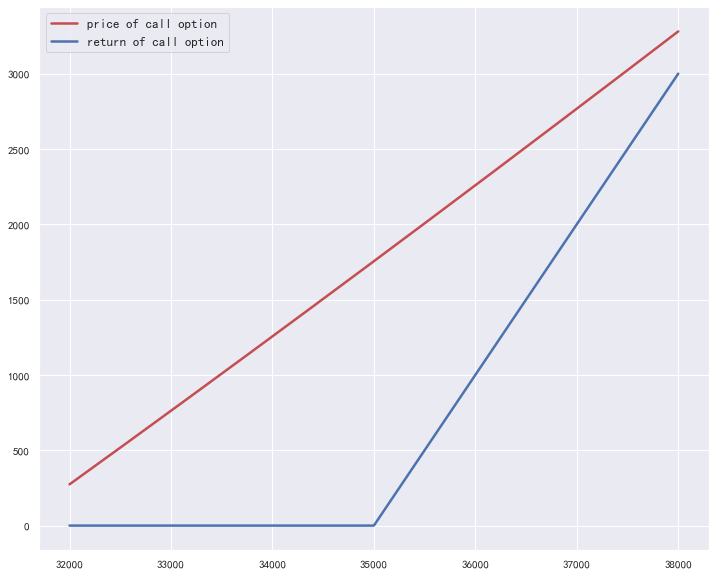

In [20]:
plt.figure(figsize=(12,10))
plt.plot(btc_price_list, value_call_list, 'r-', label=u'price of call option', lw=2.5)
plt.plot(btc_price_list, retrun_call_list, 'b-', label=u'return of call option', lw=2.5)
plt.legend(fontsize=13)
plt.show()

上述图不是真实世界的图，真实世界的看涨期权价格不会一直是纯线性的，而是带有曲线性质的。
期权价格都高于期权到期日的收益，这是因为期权价格包含了两部分：一部分是期权的内在价值( intrinsic value)，它表示假定期权在定价日就能行权所获得收益，金额等于期权到期日的收益；另一部分是期权的时间价值( time value)，它反映了期权在存续期内实现更高收益的可能性。同时，当期权处于平值时(即基础资产价格等于执行价格)，期权的时间价值达到最大。

# 计算期权隐含波动率

隐含波动率：是市场参与者对未来波动率的预期值，当合约的隐含波动率显著高于其他合约时，则该合约被高估，反之则被低估。

随着期权执行价格的上升，隐含波动率不断下降。看涨期权执行价格越低，隐含波动率越高，看跌期权执行价格越低，隐含波动率越高，但这并不是绝对的。

## 计算隐含波动率的方法：二分法和 Newton Raphson 方法

### 计算隐含波动率的二分法

举一个简单的例子，假定初始猜测某支期权的波动率是 20%，对应该波动率数值估计得到的欧式看涨期权价格是 0.1035 元，显然，比市场价格 0.1566 元更小。由于期权价格是波动率的增函数，因此合理地估计正确的波动率应该会比 20%更大。然后假定波动率是 30%，对应的期权价格 0.336 元，这个结果又比 0.1566 元高，则可以肯定波动率是介于 20%-30%的区间中。接下来，取上两次波动率数值的均值，也就是波动率 25%，对应的期权价为 0.1662 元，这个值又比 0.1566 元高，但是合理的波动率所处的区间范围收窄至 20%与 25%之间，然后取均值 22.5%继续计算，每次迭代都使波动率所处的区间减半，最终就可以计算出满足较高精确度的隐含波动率近似值。

在系列连载第 145 篇中，我们讲到法博齐等人在《金融经济学》中提出了两种计算隐含波动率的方法，分别是二分法和 Newton Raphson 算法，这两种方法在 Timothy Sauer 的《数值分析》中有详细介绍。

首先举例说明二分法，假设某日微软的股票价格为\\$80.8375，并且执行价格为\\$85 的看涨期权售价\\$2. 875。另外还有额外信息：S= \\$80.375，X= \\$85，T= 0.1945，r= 2.79%，d = 0.0。

对任何给定的 σ，我们就可以利用布莱克斯科尔斯公式来计算看涨期权的价格。尽管我们现在知道 C=$2.875，但是隐含波动率 σ 是未知的需要倒推才能得到。

为了找到 σ，我们可以从一个低σ值和一个高 σ 值开始。一个 σ= 10%大致说明，在下一年，股票价格有可能上涨 10%，也有可能下跌 10%，并且有可能是大多数股票波动率的低的估计值。另一方面，σ=100%就是一个高的估计值。计算 σ=10%时的看涨期权价格，标记为 C(σ=0.10)，同样计算 σ= 100%时的看涨期权价格，我们有 C(σ=0.10) = \\$0.2278，C(σ= 1.00) = \\$12. 4018。

由于观测到的价格 C= \\$2. 875 在 C(σ=0.10)和 C(σ=1.00)之间，由于看涨期权价格是波动率的增函数，波动率必须在 0.10 到 1.00 之间。

现在计算 0.10 和 1.00 中点的看涨期权价格，我们有 C(σ= 0.55) = \\$6.0472，由于观测到的价格 C= \\$2. 875 在C(σ=0.10)和 C(σ=0.55)之间，波动率就必须在 0. 10 和 0.55 之间。计算 0.10 和 0.55 中点的看涨期权价格，我们有 C(σ= 0.325) = \\$2.9168。

由于观测到的价格 C= \\$2. 875 在 C(σ=0.10)和 C(σ=0.325)之间，波动率就必须在 0.10 和 0.325 之间。计算 0. 10和 0.325 中点的看涨期权价格，我们有 C(σ= 0.2125)= \\$1.4361。

由于观测到的价格 c= \\$2. 875 在 C(σ=0.2125)和 C(σ= 0.325)之间，波动率就必须在 0.2125 和 0.325 之间。继续上面的过程，我们将发现

#### 二分法第一种代码

因此，隐含波动率为 σ=0.3219=32.19%。可以非常容易地利用计算机对上述过程编程，从而迅速找到隐含波动率。上述方法称为二分法。总体来说，这里编程的思想是不断给与更高与更低的波动率数值，以找到所对应的期权所对应的波动率。

In [21]:
def implied_volatility(P, S, K, r, T0, T1, optype):
    T = (T1 - T0).apply(lambda x: x.days) / 365  # 计算期权的剩余期限
    sigma_min = 0.00001
    sigma_max = 1.000
    sigma_mid = (sigma_min + sigma_max) / 2
    
    if optype == 'C':
        
        def call_bs(S, K, sigma, r, T):
            d1 = (np.log(S/K) + (r + pow(sigma, 2) / 2) * T) / (sigma * np.sqrt(T))
            d2 = d1 - sigma * np.sqrt(T)
            call_value = S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)
            return call_value
        
        call_min = call_bs(S, K, sigma_min, r, T)
        call_max = call_bs(S, K, sigma_max, r, T)
        call_mid = call_bs(S, K, sigma_mid, r, T)
        diff = P - call_mid
        
        if P < call_min or P > call_max:
            print('error, the price of option is beyond the limit')
        
        while abs(diff) > 1e-6:
            diff = P - call_bs(S, K, sigma_mid, r, T)
            sigma_mid = (sigma_min + sigma_max) / 2
            call_mid = call_bs(S, K, sigma_mid, r, T)
            if P > call_mid:
                sigma_min = sigma_mid
            else:
                sigma_max = sigma_mid
    
    else:
        
        def put_bs(S, K, sigma, r, T):
            d1 = (np.log(S/K) + (r + pow(sigma, 2) / 2) * T) / (sigma * np.sqrt(T))
            d2 = d1 - sigma * np.sqrt(T)
            put_value = K * np.exp(-r*T) * norm.cdf(-d2) - S * norm.cdf(-d1) 
            return put_value
        
        put_min = put_bs(S, K, sigma_min, r, T)
        put_max = put_bs(S, K, sigma_max, r, T)
        put_mid = put_bs(S, K, sigma_mid, r, T)
        diff = P - put_mid
        
        if P < put_min or P > put_max:
            print('error, the price of option is beyond the limit')
        
        while abs(diff) > 1e-6:
            diff = P - put_bs(S, K, sigma_mid, r, T)
            sigma_mid = (sigma_min + sigma_max) / 2
            put_mid = put_bs(S, K, sigma_mid, r, T)
            if P > put_mid:
                sigma_min = sigma_mid
            else:
                sigma_max = sigma_mid
    return sigma_mid

上面代码中，当误差 diff 小于 0.000001，返回 sigma_mid 的值，sigma_mid 的值即为我们所求的期权的隐含波动率的值。

#### 二分法第二种代码

第二种方法是利用二分查找法并运用 Python 构建分别计算欧式看涨、看跌期权隐含波动率的自定义函数,具体的代码如下，这种方法是分别定义了看涨期权隐含波动率和看跌期权隐含波动率的函数算法，且少输入了一个参数

In [9]:
def impvol_call_binary(C, S, K, r, T):
    try:
        C, S, K = float(C), float(S), float(K)
    except:
        pass
    
    def call_bs(S, K, sigma, r, T):
        d1 = (np.log(S/K) + (r + pow(sigma, 2) / 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        return float(S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2))
    
    sigma_min = 0.001
    sigma_max = 1.000
    sigma_mid = (sigma_min + sigma_max) / 2
    call_min = call_bs(S, K, sigma_min, r, T)
    call_max = call_bs(S, K, sigma_max, r, T)
    call_mid = call_bs(S, K, sigma_mid, r, T)
    diff = C - call_mid
    if (C < call_min) or (C > call_max):
        print('error, the price of option is beyond the limit')

    while abs(diff) > 0.001:
        diff = C - call_bs(S, K, sigma_mid, r, T)
        sigma_mid = (sigma_max + sigma_min) / 2
        call_mid = call_bs(S, K, sigma_mid, r, T)
        if C > call_mid:
            sigma_min = sigma_mid
        else:
            sigma_max = sigma_mid
    return sigma_mid


def impvol_put_binary(P, S, K, r, T):
    try:
        P, S, K = float(P), float(S), float(K)
    except:
        pass
    def put_bs(S, K, sigma, r, T):
        d1 = (np.log(S/K) + (r + pow(sigma, 2) / 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        return float(K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1))
    
    sigma_min = 0.001
    sigma_max = 1.000
    sigma_mid = (sigma_min + sigma_max) / 2
    put_min = put_bs(S, K, sigma_min, r, T)
    put_max = put_bs(S, K, sigma_max, r, T)
    put_mid = put_bs(S, K, sigma_mid, r, T)
    diff = P - put_mid
    
    if P < put_min or P > put_max:
        print('error, the price of option is beyond the limit')

    while abs(diff) > 0.001:
        diff = P - put_bs(S, K, sigma_mid, r, T)
        sigma_mid = (sigma_max + sigma_min) / 2
        put_mid = put_bs(S, K, sigma_mid, r, T)
        if P > put_mid:
            sigma_min = sigma_mid
        else:
            sigma_max = sigma_mid
    return sigma_mid

依然沿用BTC期权作为分析对象

In [20]:
option_thing_2 = df[(df['symbol'] == 'BTC-USD-210702-35000-P') & (df['candle_begin_time'] == pd.to_datetime('2021-06-24'))]
# 原始数据开高收低单位为BTC，通过乘以BTC价格获得当时期权价格
option_thing_2[['open', 'high', 'low', 'close']] = option_thing_2.loc[:, ('open', 'high', 'low', 'close')].apply(lambda x: x * option_thing_2['btc_price'])
option_thing_2

C:\Users\xueli\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,candle_begin_time,open,high,low,close,volume,currency_volume,symbol,T1,K,types,btc_price,btc_return,btc_volatility,_merge
3441,2021-06-24,1733.1545,1733.1545,1733.1545,1733.1545,0.0,0.0,BTC-USD-210702-35000-P,2021-07-02,35000,P,34663.09,0.028829,0.756979,both


In [90]:
imp_vol_1 = impvol_call_binary(C=option_thing['close'], S=option_thing['btc_price'], K=option_thing['K'], r=0.04, T=(option_thing['T1'] - option_thing['candle_begin_time']).apply(lambda x: x.days) / 365)
imp_vol_1

0.7114614081382752

In [21]:
imp_vol_2 = impvol_put_binary(P=option_thing_2['close'], S=option_thing_2['btc_price'], K=option_thing_2['K'], r=0.04, T=(option_thing_2['T1'] - option_thing_2['candle_begin_time']).apply(lambda x: x.days) / 365)
imp_vol_2

0.766494839668274

**这里在计算中出现问题，有的数据会出现error的原因**：[波动率为0，看涨期权的价格下限为0.65左右，大于市场价0.6248，这个时候期权实际价格已经低于理论价格，BS公式超出其计算范围，用隐波已无法衡量实际价格的合理性了。期权客户端报价隐含波动率一栏有些显示“-”或者“0.0001”也是这个道理](https://blog.csdn.net/hzk427/article/details/104501847/ '小粉桥反手王CSDN')

此外,隐含波动率也正在被制作成指数。比如,芝加哥期权交易所(CBOE）于 1993 年对外发布了隐含波动率的指数 VIX( Volatility Index)，VIX 也被称作"恐惧指数"(fear factor）。此后，德国、法国、英国、瑞士、韩国等国家及我国的香港、台湾地区也相继推出了波动率指数国际经验表明，波动率指数能够前瞻性地反映市场情绪与风险。例如，在 2008 年国际全融危机中，波动率指数及时准确地为全球各家金融监管机构提供了掌握市场压力、监控市场情绪的指标，有效提升了监管能力与决策水平。

2015 年 6 月 26 日，上海证券交易所发布了首只基于真实期权交易数据编制的波动率数中国波指(iVIX)中国波指是用于衡量上证 50FTF 基金未来 30 日的预期波动，它的推出一方面为市场提供了高效灵敏的风险监测指标，便于市场实时衡量市场风险，增强技术分析手段，提升策略交易能力；另一方面也对进一步丰富上海证券交易所的衍生产品种类、实现行生品发展战略产生了积极意义。

### 计算隐含波动率的牛顿迭代法

#### 牛顿迭代法的数学推导

简单来说，这一算法是找到一个方程的根，即从任意初始值x0开始，根据下式不断迭代，获得 f(x)=0 的解。

牛顿方法对应的几何图如下图所示。为了找到函数 f(x)=0 的根，给定一个初始估计x0，画出函数 f 在x0点的切线。用切线来近似函数 f，求出其与 x 轴的交点作为函数 f 的根，但是由于函数的弯曲，该交点可能并不是精确解。因而，该步骤要迭代进行。

![](options/1-1-newton.jpg)

从x0开始，画出函数 y=f(x)的切线和 x 轴的交点记做x1，这是对于函数根的下一个近似。并且可以看到，再将x1代入 f（x）中求其切线，就可以得到一个更近的数值。从几何图像中我们可以推出牛顿方法的公式，x0点的切线斜率可由导数 f(x)给出，并且切线上的一点是（x0，f(x0)）。

我们先回顾一下点斜式公式，设 Q（x，y）是直线 l 上不同于点 P 的任一点，由于点 P，Q 都在 l 上，所以，可以用点 P(x0，y0)的坐标来表示直线 l 的斜率，于是可得以下方程： $y-y+_0=k(x-x_0)$

这就是所求的过点 P(x0，y0)，斜率为 k 的直线 l 的方程，这个方程是由直线上的一点和斜率（一个方向）所确定的，称为直线方程的点斜式。

一般地，如果一条直线 l 上任意点的坐标（x，y）都满足一个方程，满足该方程的每一个数对（x，y）所确定的点都在直线 l 上，我们就把这个方程称为直线 l 的方程。如果已知直线 l 上一点 P(x0，y0)及斜率 k，可用上述方法求出直线 l 的方程。

我们来看一下 Timothy Sauer 所写的《数值分析》，由于在 Newton Raphson 中，一条直线的点斜率方程是y − f(x0) = f’(x0)(x − x0)，因而切线和 x 轴的交点等价于在直线中令 y=0：

$$
\begin{align}
&f'(x_0)-(x-x_0)=0-f(x_0)\\
&x-x_0=-\frac{f(x_0)}{f'(x_0)}\\
&x=x_0-\frac{f(x_0)}{f'(x_0)}\\
\end{align}
$$

求解 x 得到根的近似，称为x1，然后，重复整个过程，从x1开始，得到x2，等等，进而得到如下的迭代公式：牛顿方法是：x0=初始估计，xi+1 = xi −f(xi) / f’(xi)，其中 i=0，1，2，3，。。。，直到收敛，具体可以见上图。

下面将牛顿迭代方法应用到期权定价中。构造函数f(σ) = C(σ = σi) − C，其中C是当前已知即时期权价格，那么波动率就是对f(σ) =0 求解，并且可以知道隐含波动率的数值是唯一的。

首先需要算出f(σ)的导数 $f'(\sigma)=e^{d_1^2/2}\sqrt{2\pi}(S\sqrt T)$, 并且最后能够得到牛顿迭代公式：$\sigma_{i+1}=\sigma_i-[C(\sigma=\sigma_i)-C]\times e^{d_1^2/2}\sqrt{2\pi}(S\sqrt T)$，i=0，1，2，3，...，直到收敛。

牛顿迭代法计算波动率公式：$\sigma_{i+1}=\sigma_i-\frac{f(\sigma)}{f'(\sigma)}$，关键在于求$f'(\sigma)$

尽管交易者有可能会获得不同的历史波动率估计，但是如果他们认同布莱克斯科尔斯公式，那么他们对隐含波动率的估计应该是相同的。隐含波动率代表当前市场对标的证券的波动率的估计，有助于股票投资者估计当前波动率，从而如果发现波动率已经很高，将要达到一个更高的 u 或者更低的 d 时，就会破坏金融市场的稳定性，从而可以让我们在理论上在波动率很高，u 很高选择卖出长期沪深 300 看涨期权；在波动率很低，u 很低选择买入长期沪深 300 看涨期权。



#### 运用牛顿迭代法计算隐波的python实现

牛顿迭代法(Newton's Method),也称为牛顿-拉弗森方法(Newton-Raphson method)，在利用该方法计算期权的隐含波动率时,需要做好以下 3 个方面的工作：一是需要输入一个初始的隐含波动率；二是建立一种迭代关系式，如果由初始的隐含波动率得到的期权价格高于市场价格,则需要减去一个标量(比如 0.0001),相反则加上一个标量;三是需要对选代过程进行控制, 也就是针对隐含波动率得到的期权价格与期权的市场价格之间的差额设置一个可接受的临界值。

In [125]:
def impvol_call_newton(C, S, K, r, T):
    try:
        C, S, K = float(C), float(S), float(K)
    except:
        pass
    
    def call_bs(S, K, sigma, r, T):
        d1 = (np.log(S/K) + (r + pow(sigma, 2) / 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        return float(S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2))
    sigma_0 = 0.2
    diff = C - call_bs(S, K, sigma_0, r, T)
    i = 0.00001
    while abs(diff) > 0.001:
        diff = C - call_bs(S, K, sigma_0, r, T)
        if diff > 0:
            sigma_0 += i
        else:
            sigma_0 -= i
    return sigma_0


def impvol_put_newton(P, S, K, r, T):
    try:
        P, S, K = float(P), float(S), float(K)
    except:
        pass
    
    def put_bs(S, K, sigma, r, T):
        d1 = (np.log(S/K) + (r + pow(sigma, 2) / 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        return float(K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1))
    sigma_0 = 0.2
    diff = P - put_bs(S, K, sigma_0, r, T)
    i = 0.00001
    print(diff)
    while abs(diff) > 0.001:
        if abs(diff) > 1:
            i = 0.001
        else:
            i = 0.0000001
        diff = P - put_bs(S, K, sigma_0, r, T)
        if diff > 0:
            sigma_0 += i
        else:
            sigma_0 -= i
        print(diff, sigma_0)
    return sigma_0

In [126]:
imp_vol_3 = impvol_call_newton(C=option_thing['close'], S=option_thing['btc_price'], K=option_thing['K'], r=0.04, T=(option_thing['T1'] - option_thing['candle_begin_time']).apply(lambda x: x.days) / 365)
imp_vol_3

KeyboardInterrupt: 

In [123]:
imp_vol_4 = impvol_put_newton(P=option_thing_2['close'], S=option_thing_2['btc_price'], K=option_thing_2['K'], r=0.04, T=(option_thing_2['T1'] - option_thing_2['candle_begin_time']).apply(lambda x: x.days) / 365)
imp_vol_4

1150.7746238246466
1150.7746238246466 0.201
1148.8068707574523 0.202
1146.8382642944882 0.203
1144.868816728412 0.20400000000000001
1142.8985401197635 0.20500000000000002
1140.9274463023787 0.20600000000000002
1138.9555468886858 0.20700000000000002
1136.9828532747663 0.20800000000000002
1135.0093766453895 0.20900000000000002
1133.0351279788295 0.21000000000000002
1131.060118051569 0.21100000000000002
1129.0843574429048 0.21200000000000002
1127.1078565393975 0.21300000000000002
1125.1306255392149 0.21400000000000002
1123.1526744563519 0.21500000000000002
1121.1740131247527 0.21600000000000003
1119.1946512023162 0.21700000000000003
1117.2145981747738 0.21800000000000003
1115.2338633595166 0.21900000000000003
1113.252455909281 0.22000000000000003
1111.2703848157173 0.22100000000000003
1109.2876589129512 0.22200000000000003
1107.3042868809782 0.22300000000000003
1105.3202772489633 0.22400000000000003
1103.335638398533 0.22500000000000003
1101.350378566901 0.22600000000000003
1099.364505849

654.9633563421551 0.44700000000000023
652.9262961083361 0.44800000000000023
650.8891603527547 0.44900000000000023
648.8519496217298 0.45000000000000023
646.814664456869 0.45100000000000023
644.7773053951162 0.45200000000000023
642.7398729687986 0.45300000000000024
640.7023677056561 0.45400000000000024
638.6647901289282 0.45500000000000024
636.6271407573797 0.45600000000000024
634.5894201053518 0.45700000000000024
632.5516286828272 0.45800000000000024
630.5137669954413 0.45900000000000024
628.4758355445695 0.46000000000000024
626.4378348273524 0.46100000000000024
624.3997653367326 0.46200000000000024
622.3616275615234 0.46300000000000024
620.323421986431 0.46400000000000025
618.2851490921269 0.46500000000000025
616.2468093552482 0.46600000000000025
614.2084032484738 0.46700000000000025
612.1699312405574 0.46800000000000025
610.1313937963707 0.46900000000000025
608.0927913769476 0.47000000000000025
606.054124439502 0.47100000000000025
604.0153934374969 0.47200000000000025
601.97659882068

174.95686510134624 0.6820000000000004
172.9109721785601 0.6830000000000004
170.8650641347151 0.6840000000000004
168.81914108076603 0.6850000000000004
166.77320312708184 0.6860000000000004
164.7272503834604 0.6870000000000004
162.6812829591247 0.6880000000000004
160.6353009627303 0.6890000000000004
158.58930450236517 0.6900000000000004
156.54329368557887 0.6910000000000004
154.49726861932436 0.6920000000000004
152.45122941003433 0.6930000000000004
150.40517616359216 0.6940000000000004
148.35910898531733 0.6950000000000004
146.3130279800091 0.6960000000000004
144.26693325192832 0.6970000000000004
142.22082490478647 0.6980000000000004
140.17470304178573 0.6990000000000004
138.12856776559715 0.7000000000000004
136.08241917836062 0.7010000000000004
134.036257381714 0.7020000000000004
131.99008247677853 0.7030000000000004
129.9438945641516 0.7040000000000004
127.8976937439395 0.7050000000000004
125.85148011574643 0.7060000000000004
123.80525377866729 0.7070000000000004
121.75901483129496 0.7

1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005

-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005

-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005

1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005

-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005

-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005

1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005

-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005

1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005

1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005

-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005

-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005

-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005

1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005

1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005

-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005

1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005

1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005

1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005

1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005

1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005

1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005

1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005

-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005

-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005

1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005

1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005

-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005

1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005

-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005

-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005

1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005

-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005
-1.0349404717351263 0.7660000000000005
1.0118915132145503 0.7670000000000005

KeyboardInterrupt: 

不知道是什么原因，可能是期权价格过高导致？总之会卡在一个无限循环里。

作者也说由于计算的步骤会比较多，因此牛顿迭代法的效率往往是比较低的，如果将结果的精确度进一步提高，则需要花费比较长的时间进行运算。因此，从 Python 代码运行的效率来看，二分法比牛顿迭代法更适用。

## 期权隐含波动率分析

### 计算隐含波动率时间序列并可视化

In [4]:
def implied_volatility(P, S, K, r, T0, T1, types):
    try:
        P, S, K, types = float(P), float(S), float(K), types.tolist()[0]
        T = (T1 - T0).apply(lambda x: x.days) / 365  # 计算期权的剩余期限
    except:
        P, S, K = float(P), float(S), float(K)
        T = (T1-T0).days / 365
        pass
    
    
    sigma_min = 0.001
    sigma_max = 1.000
    sigma_mid = (sigma_min + sigma_max) / 2
    
    if types == 'C':
        
        def call_bs(S, K, sigma, r, T):
            d1 = (np.log(S/K) + (r + pow(sigma, 2) / 2) * T) / (sigma * np.sqrt(T))
            d2 = d1 - sigma * np.sqrt(T)
            return float(S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2))
        
        call_min = call_bs(S, K, sigma_min, r, T)
        call_max = call_bs(S, K, sigma_max, r, T)
        call_mid = call_bs(S, K, sigma_mid, r, T)
        diff = P - call_mid
        if (P < call_min) or (P > call_max):
            print('error, the price of option is beyond the limit')
            sigma_mid = np.nan
            return sigma_mid
        else:
            while abs(diff) > 0.001:
                diff = P - call_bs(S, K, sigma_mid, r, T)
                sigma_mid = (sigma_max + sigma_min) / 2
                call_mid = call_bs(S, K, sigma_mid, r, T)
                if P > call_mid:
                    sigma_min = sigma_mid
                else:
                    sigma_max = sigma_mid
    else:
        
        def put_bs(S, K, sigma, r, T):
            d1 = (np.log(S/K) + (r + pow(sigma, 2) / 2) * T) / (sigma * np.sqrt(T))
            d2 = d1 - sigma * np.sqrt(T)
            return float(K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1))
        
        put_min = put_bs(S, K, sigma_min, r, T)
        put_max = put_bs(S, K, sigma_max, r, T)
        put_mid = put_bs(S, K, sigma_mid, r, T)
        diff = P - put_mid
        
        if P < put_min or P > put_max:
            print('error, the price of option is beyond the limit')
            sigma_mid = np.nan
            return sigma_mid
        else:
            while abs(diff) > 1e-6:
                diff = P - put_bs(S, K, sigma_mid, r, T)
                sigma_mid = (sigma_min + sigma_max) / 2
                put_mid = put_bs(S, K, sigma_mid, r, T)
                if P > put_mid:
                    sigma_min = sigma_mid
                else:
                    sigma_max = sigma_mid
    return sigma_mid

我们选取三个同时期不同行权价的合约：

In [190]:
df_option_impvol_final = pd.DataFrame()
for _ in ['BTC-USD-210702-34000-C', 'BTC-USD-210702-35000-C', 'BTC-USD-210702-36000-C']:
    df_option_impvol = df[(df['symbol'] == _)]
    # 原始数据开高收低单位为BTC，通过乘以BTC价格获得当时期权价格
    df_option_impvol[['open', 'high', 'low', 'close']] = df_option_impvol.loc[:, ('open', 'high', 'low', 'close')].apply(lambda x: x * df_option_impvol['btc_price'])
    # 使用矩阵运算，看了下函数代码可以直接矩阵运算，一方面是快，另一方面不知道怎么对series进行apply函数操作，输入的值为series；
    # 那么我只能想到用for循环一个个代，但这样处理大数据就慢很多了；
    P221, S221, K221, T0_221, T1_221, types221 = df_option_impvol['close'].to_list(), df_option_impvol['btc_price'].to_list(), df_option_impvol['K'].to_list(), df_option_impvol['candle_begin_time'].to_list(), df_option_impvol['T1'].to_list(), df_option_impvol['types'].to_list()  
    impvol = []
    for i in range(len(P221)):
        impvol.append(implied_volatility(P221[i], S221[i], K221[i], 0.04, T0_221[i], T1_221[i], types221[i]))
    df_option_impvol['impvol'] = impvol
    df_option_impvol_final = pd.concat([df_option_impvol_final, df_option_impvol], axis=0)

df_option_impvol_final

C:\Users\xueli\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\xueli\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


error, the price of option is beyond the limit
error, the price of option is beyond the limit
error, the price of option is beyond the limit
error, the price of option is beyond the limit
error, the price of option is beyond the limit
error, the price of option is beyond the limit
error, the price of option is beyond the limit


,candle_begin_time,open,high,low,close,volume,currency_volume,symbol,T1,K,types,btc_price,btc_return,btc_volatility,_merge,impvol
3438,2021-06-24,1681.159865,1681.159865,1681.159865,1681.159865,0.0,0.0,BTC-USD-210702-34000-C,2021-07-02,34000,C,34663.09,0.028829,0.756979,both,0.644413
3564,2021-06-25,1531.845825,1531.845825,821.195700,821.195700,4.0,0.4,BTC-USD-210702-34000-C,2021-07-02,34000,C,31584.45,-0.093011,0.763074,both,0.975530
3706,2021-06-26,839.374900,839.374900,839.374900,839.374900,1.0,0.1,BTC-USD-210702-34000-C,2021-07-02,34000,C,32283.65,0.021896,0.763189,both,0.909756
3853,2021-06-27,902.208840,902.208840,902.208840,902.208840,0.0,0.0,BTC-USD-210702-34000-C,2021-07-02,34000,C,34700.34,0.072189,0.766011,both,0.283943
4011,2021-06-28,896.867140,1586.764940,896.867140,1586.764940,0.0,0.0,BTC-USD-210702-34000-C,2021-07-02,34000,C,34494.89,-0.005938,0.766032,both,0.920806
4164,2021-06-29,1651.939580,2549.732830,1651.939580,2549.732830,26.0,2.6,BTC-USD-210702-34000-C,2021-07-02,34000,C,35911.73,0.040253,0.766892,both,NaN
4310,2021-06-30,2488.195000,2488.195000,1629.592500,1629.592500,33.0,3.3,BTC-USD-210702-34000-C,2021-07-02,34000,C,35045.00,-0.024431,0.767349,both,0.998943
4449,2021-07-01,1557.968085,1557.968085,402.056280,418.808625,4.0,0.4,BTC-USD-210702-34000-C,2021-07-02,34000,C,33504.69,-0.044948,0.768860,both,0.900450
2587,2021-06-19,2448.376680,2448.376680,2448.376680,2448.376680,0.0,0.0,BTC-USD-210702-35000-C,2021-07-02,35000,C,35483.72,-0.009428,0.747542,both,0.819689
2741,2021-06-20,2456.411040,2456.411040,1673.207520,1673.207520,0.0,0.0,BTC-USD-210702-35000-C,2021-07-02,35000,C,35600.16,0.003276,0.747540,both,0.519501


In [191]:
# 使用透视图查看
df_option_impvol_final = pd.pivot_table(df_option_impvol_final, columns='symbol', values='impvol', index='candle_begin_time')
df_option_impvol_final.fillna(method='ffill', inplace=True)
df_option_impvol_final.fillna(value=0, inplace=True)
df_option_impvol_final

symbol,BTC-USD-210702-34000-C,BTC-USD-210702-35000-C,BTC-USD-210702-36000-C
candle_begin_time,,,
2021-06-19,0.000000,0.819689,0.000000
2021-06-20,0.000000,0.519501,0.623209
2021-06-22,0.000000,0.711461,0.840485
2021-06-23,0.000000,0.711461,0.952016
2021-06-24,0.644413,0.839894,0.727928
2021-06-25,0.975530,0.839894,0.965589
2021-06-26,0.909756,0.839894,0.888959
2021-06-27,0.283943,0.905245,0.604938
2021-06-28,0.920806,0.992272,0.897604


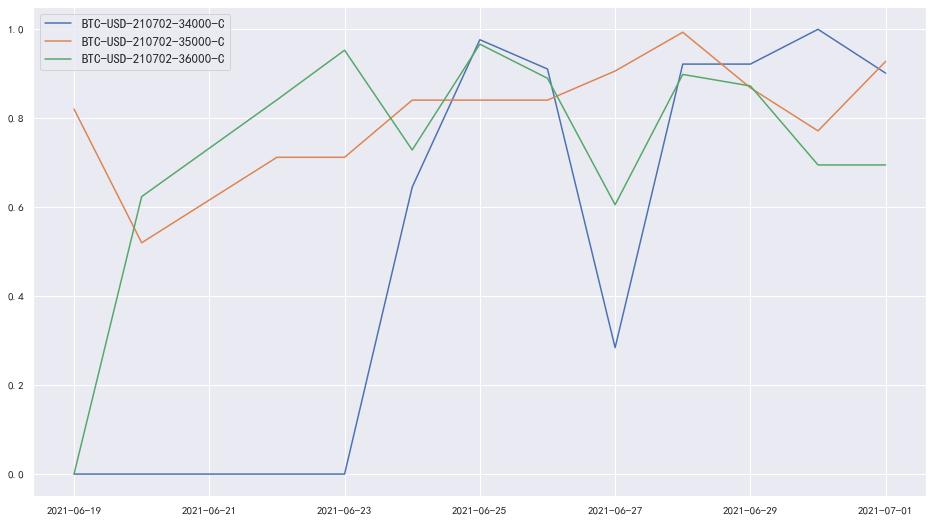

In [196]:
plt.figure(figsize=(16,9))
for label in df_option_impvol_final.columns:
    plt.plot(df_option_impvol_final[label], label=label)
plt.legend(fontsize=13)
plt.show()

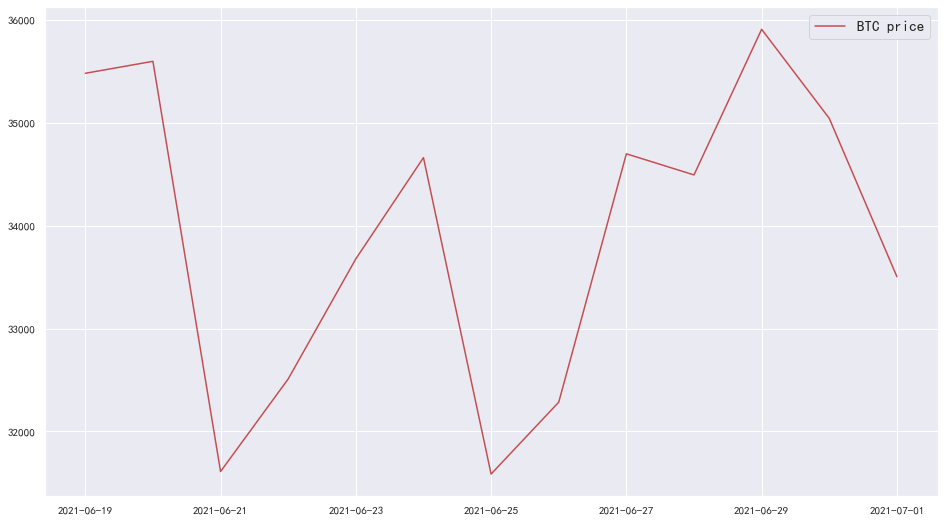

In [205]:
plt.figure(figsize=(16, 9))
plt.plot(df_btc.loc[df_btc['candle_begin_time'].between('2021-06-19', '2021-07-01')].set_index('candle_begin_time'), label=u'BTC price', color='r')
plt.legend(fontsize=15)
plt.show()

# 波动率微笑与斜偏

## 波动率微笑

波动率微笑(volatility smile）是一种描述期权隐含波动率与执行价格函数关系的图形具体是指针对相同的到期日和基础资产、但不同执行价格的期权,当执行价格偏离基础资产现货价格越远时，期权的波动率就越大，类似于微笑曲线。

波动率微笑是指，当在某一天，不同执行价格的看涨期权会有不同的隐含波动率，我们列出某一天看涨期权在不同执行价格下的不同隐含波动率，并将其画成一条曲线，并称为波动率微笑曲线。

C:\Users\xueli\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\xueli\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\xueli\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

error, the price of option is beyond the limit
error, the price of option is beyond the limit
error, the price of option is beyond the limit
error, the price of option is beyond the limit
error, the price of option is beyond the limit
error, the price of option is beyond the limit
error, the price of option is beyond the limit
error, the price of option is beyond the limit
error, the price of option is beyond the limit
error, the price of option is beyond the limit
error, the price of option is beyond the limit
error, the price of option is beyond the limit
error, the price of option is beyond the limit
error, the price of option is beyond the limit
error, the price of option is beyond the limit
error, the price of option is beyond the limit
error, the price of option is beyond the limit
error, the price of option is beyond the limit
error, the price of option is beyond the limit
error, the price of option is beyond the limit


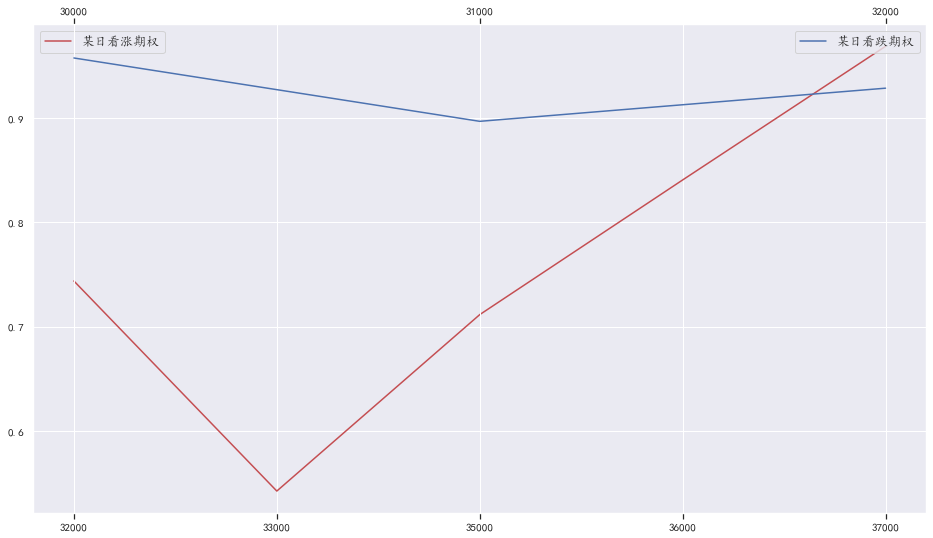

In [86]:
# 取某个到期日、某一天的看涨期权
df_option_smile_c = df[(df['T1'] == '2021-07-02') & (df['candle_begin_time'] == '2021-06-22') & (df['types'] == 'C')]
# df_option_smile_c
df_option_smile_c_final = pd.DataFrame()
# 原始数据开高收低单位为BTC，通过乘以BTC价格获得当时期权价格
df_option_smile_c[['open', 'high', 'low', 'close']] = df_option_smile_c.loc[:, ('open', 'high', 'low', 'close')].apply(lambda x: x * df_option_smile_c['btc_price'])
# 计算隐波
P_smile_c, S_smile_c, K_smile_c, T0_smile_c, T1_smile_c, types_smile_c = df_option_smile_c['close'].to_list(), df_option_smile_c['btc_price'].to_list(), df_option_smile_c['K'].to_list(), df_option_smile_c['candle_begin_time'].to_list(), df_option_smile_c['T1'].to_list(), df_option_smile_c['types'].to_list()  
impvol = []
for i in range(len(P_smile_c)):
    impvol.append(implied_volatility(P_smile_c[i], S_smile_c[i], K_smile_c[i], 0.04, T0_smile_c[i], T1_smile_c[i], types_smile_c[i]))
df_option_smile_c['impvol'] = impvol
df_option_smile_c_final = pd.concat([df_option_smile_c_final, df_option_smile_c], axis=0)

# 取某个到期日、某一天的看涨期权
df_option_smile_p = df[(df['T1'] == '2021-07-02') & (df['candle_begin_time'] == '2021-06-25') & (df['types'] == 'P')]
# df_option_smile_p
df_option_smile_p_final = pd.DataFrame()
# 原始数据开高收低单位为BTC，通过乘以BTC价格获得当时期权价格
df_option_smile_p[['open', 'high', 'low', 'close']] = df_option_smile_p.loc[:, ('open', 'high', 'low', 'close')].apply(lambda x: x * df_option_smile_p['btc_price'])
# 计算隐波
P_smile_c, S_smile_c, K_smile_c, T0_smile_c, T1_smile_c, types_smile_c = df_option_smile_p['close'].to_list(), df_option_smile_p['btc_price'].to_list(), df_option_smile_p['K'].to_list(), df_option_smile_p['candle_begin_time'].to_list(), df_option_smile_p['T1'].to_list(), df_option_smile_p['types'].to_list()  
impvol = []
for i in range(len(P_smile_c)):
    impvol.append(implied_volatility(P_smile_c[i], S_smile_c[i], K_smile_c[i], 0.04, T0_smile_c[i], T1_smile_c[i], types_smile_c[i]))
df_option_smile_p['impvol'] = impvol
df_option_smile_p_final = pd.concat([df_option_smile_p_final, df_option_smile_p], axis=0)

# 画图
fig, ax1 = plt.subplots(figsize=(16,9))
ax2 = ax1.twiny()    # mirror the ax1
ax1.plot(df_option_smile_c_final['K'], df_option_smile_c_final['impvol'], label='某日看涨期权', color='r')
ax1.legend(fontsize=13)
ax2.plot(df_option_smile_p_final['K'], df_option_smile_p_final['impvol'], label='某日看跌期权', color='b')
ax2.legend(fontsize=13)
plt.show()

上图刻画了 2021 年 6 月 22 日和25日比特币认购期权、认沽期权的隐含波动率与执行价格之间的关系，没有选择同一日的原因在于一个没有解决的问题——有很多期权超出了BS算出来的值，上述已讨论过原因，另外观察交易所网站给出的数据，发现确实很多时候隐波非常大；另外目前数据“微笑”比较难找，斜偏倒是好找。

![](options/1-2-optionprice.png)

无论是看涨期权还是看跌期权，当期权执行价格越接近于基础资产价格时，期权的隐含波动率基本上就越低；越远离基础资产价格时,则隐含波动率越高，因此存在着比较明显的波动率微笑特征。

## 波动率斜偏

然而，在大多数交易日，股票期权的波动率曲线不是微笑的，而是表现为波动率偏斜（volatility skew）。狭义波动率偏斜则是指当期权的执行价格由小变大时，期权的隐含波动率则是由大变小，即隐含波动率是执行价格的减函数。

C:\Users\xueli\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\xueli\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\xueli\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

error, the price of option is beyond the limit
error, the price of option is beyond the limit
error, the price of option is beyond the limit
error, the price of option is beyond the limit
error, the price of option is beyond the limit
error, the price of option is beyond the limit
error, the price of option is beyond the limit
error, the price of option is beyond the limit
error, the price of option is beyond the limit
error, the price of option is beyond the limit
error, the price of option is beyond the limit
error, the price of option is beyond the limit
error, the price of option is beyond the limit
error, the price of option is beyond the limit
error, the price of option is beyond the limit
error, the price of option is beyond the limit
error, the price of option is beyond the limit
error, the price of option is beyond the limit
error, the price of option is beyond the limit
error, the price of option is beyond the limit


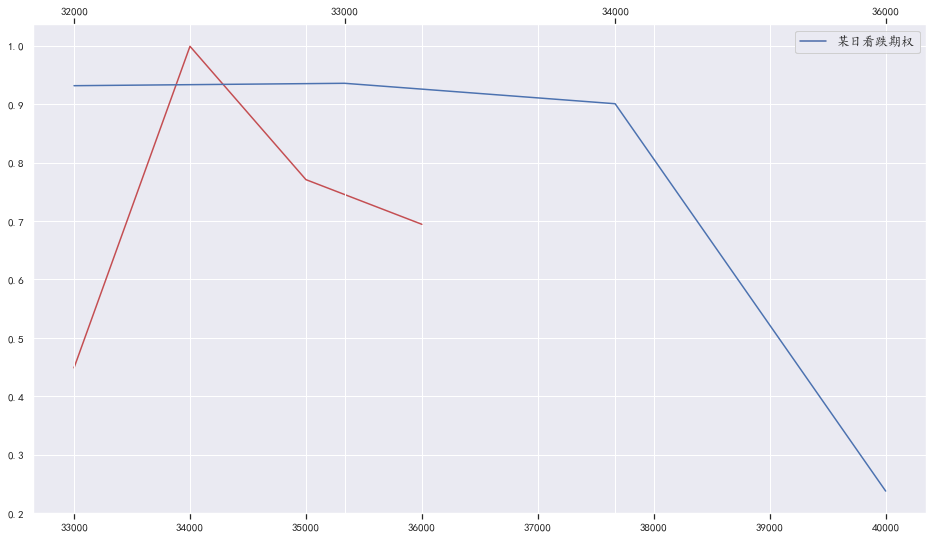

In [9]:
# 取某个到期日、某一天的看涨期权
df_option_smile_c = df[(df['T1'] == '2021-07-02') & (df['candle_begin_time'] == '2021-06-30') & (df['types'] == 'C')]
# df_option_smile_c
df_option_smile_c_final = pd.DataFrame()
# 原始数据开高收低单位为BTC，通过乘以BTC价格获得当时期权价格
df_option_smile_c[['open', 'high', 'low', 'close']] = df_option_smile_c.loc[:, ('open', 'high', 'low', 'close')].apply(lambda x: x * df_option_smile_c['btc_price'])
# 计算隐波
P_smile_c, S_smile_c, K_smile_c, T0_smile_c, T1_smile_c, types_smile_c = df_option_smile_c['close'].to_list(), df_option_smile_c['btc_price'].to_list(), df_option_smile_c['K'].to_list(), df_option_smile_c['candle_begin_time'].to_list(), df_option_smile_c['T1'].to_list(), df_option_smile_c['types'].to_list()  
impvol = []
for i in range(len(P_smile_c)):
    impvol.append(implied_volatility(P_smile_c[i], S_smile_c[i], K_smile_c[i], 0.04, T0_smile_c[i], T1_smile_c[i], types_smile_c[i]))
df_option_smile_c['impvol'] = impvol
df_option_smile_c_final = pd.concat([df_option_smile_c_final, df_option_smile_c], axis=0)

# 取某个到期日、某一天的看涨期权
df_option_smile_p = df[(df['T1'] == '2021-07-02') & (df['candle_begin_time'] == '2021-06-23') & (df['types'] == 'P')]
# df_option_smile_p
df_option_smile_p_final = pd.DataFrame()
# 原始数据开高收低单位为BTC，通过乘以BTC价格获得当时期权价格
df_option_smile_p[['open', 'high', 'low', 'close']] = df_option_smile_p.loc[:, ('open', 'high', 'low', 'close')].apply(lambda x: x * df_option_smile_p['btc_price'])
# 计算隐波
P_smile_c, S_smile_c, K_smile_c, T0_smile_c, T1_smile_c, types_smile_c = df_option_smile_p['close'].to_list(), df_option_smile_p['btc_price'].to_list(), df_option_smile_p['K'].to_list(), df_option_smile_p['candle_begin_time'].to_list(), df_option_smile_p['T1'].to_list(), df_option_smile_p['types'].to_list()  
impvol = []
for i in range(len(P_smile_c)):
    impvol.append(implied_volatility(P_smile_c[i], S_smile_c[i], K_smile_c[i], 0.04, T0_smile_c[i], T1_smile_c[i], types_smile_c[i]))
df_option_smile_p['impvol'] = impvol
df_option_smile_p_final = pd.concat([df_option_smile_p_final, df_option_smile_p], axis=0)

# 画图
fig, ax1 = plt.subplots(figsize=(16,9))
ax2 = ax1.twiny()    # mirror the ax1
ax1.plot(df_option_smile_c_final['K'], df_option_smile_c_final['impvol'], label='某日看涨期权', color='r')
ax1.legend(fontsize=13)
ax2.plot(df_option_smile_p_final['K'], df_option_smile_p_final['impvol'], label='某日看跌期权', color='b')
ax2.legend(fontsize=13)
plt.show()

对于执行价格较低的期权（通常是深度虚值看跌期权或深度实值看涨期权），这类期权的隐含波动率较高；相比下，对于执行价格较高的期权（通常是深度实值看跌期权或深度虚值看涨期权），此类期权的隐含波动率较低。即重要结论为：**隐含波动率是执行价格的减函数，无论是对于看涨期权还是看跌期权都是如此**。


# 看跌期权隐含波动率中的各个顶部，最终都是重要的买入信号

## 看跌期权隐含波动率中的各个顶部，最终都是重要的买入信号

在实际的应用里，麦克米伦在《麦克米伦谈期权中》第 4 章里认为隐含波动率可以用来预测趋势变动。例如，股票价格下跌，看跌期权隐含波动率上升（股票价格上涨，看涨期权隐含波动率上升）。因此，如果能够在股票即将结束下行运动时抓住它，或许会发现这些期权是处于高价位的。而且，虽然股票也许不会马上就转入牛市的趋势，但它至少会在构造底部并稳定下来。

因此，麦克米伦认为在通常情况下，当看跌期权隐含波动率在股票下跌过程中达到最高点，那么股票至少是要稳定下来，也可能甚至反弹。同样的，当看涨期权隐含波动率在股票上涨过程中达到最高点，那么股票至少是要稳定下来，不会上涨过快，而是会保持平稳，也可能出现回调。

上面这种规律应用在指数期权中的效果常常比在股票期权中更好。

当市场暴跌，看跌期权隐含波动率猛升时，市场是在接近底部。当看跌期权隐含波动率最后达到顶部并且开始下降时，市场常常已经触及底部。

反过来，如果看跌期权隐含波动率变得太低，我们就可以预见市场会有波动（并不一定是市场下跌，也不一定是市场上涨），这个波动可能发生在任一方向上。同样的，如果看涨期权隐含波动率变得太低，我们就可以预见市场有波动（并不一定是市场上涨，也不一定是市场下跌），这个波动可能发生在任一方向上。这样一来就意味着，无论是看涨期权还是看跌期权，当它们的价格到达了布林线下轨时，是无法对 A 股指数未来运行的方向进行预测的。我们只能利用当看涨期权和看跌期权价格到达布林线上轨时，才可以对 A 股指数的方向进行预测。

芝加哥期权交易所（CBOE）发布了两个非常重要的波动率指标。一个是 VIX，它是标普 500 指数期权的隐含波动率。另一个是 VXO，它是标普 100 指数期权的隐含波动率。

麦克米伦通过经验观察到多年来看跌期权隐含波动率中的各个顶部，最终都是重要的买入信号。至少来看看跌期权隐含波动率中的每一次顶部也是一次出色的中期买入点。所有人都慌乱起来并冲入市场以高得荒唐的价格买入认沽期权。这是经典的反向交易情景，此时市场实际已在底部，再买看跌期权已经没有太大的意义。

在交易中我们可以得出结论：看跌期权价格到高位，意味着看跌期权的隐含波动率到高位，意味着下跌将要结束，股价将要开始上涨；看涨期权价格到高位，意味着看涨期权的隐含波动率到高位，意味着上涨将要结束，股价将要开始下跌。

当看涨期权价格或看跌期权价格“太低”时，就意味着市场就要在某个方向上有爆发性的发展，但是常常不能肯定是哪个方向。看涨期权或看跌期权在价格到达高位时要下跌，但在低位时不能明确方向。

谢尔登.纳坦恩伯格的《期权波动率与定价高级交易策略与技巧》第 6 章里也对于波动率进行了探讨，他得出了一个重要的结论：以百分比形式，波动率的变化对虚值期权的影响将大于相应的实值期权或平值期权。

由此可知，实值期权对波动率的变化都是最不敏感的。这是因为随着期权变成深度实值期权，该期权对标的价格的变化越来越敏感，而对波动率的变化也越来越不敏感。因为投资者和交易者进入期权市场时，寻求的主要是波动率特征，所以期权市场中绝大部分交易量都集中在对波动力率变化最为敏感的平值期权和虚值期权上。所以我们要理解，期权最重要的投资原因是波动率，也就是择时，在底部时认为 A 股要涨，在顶部时认为 A 股要跌，这就是进行期权投资的主要用途，这就使得期权非常重视对于波动率的交易。

## 计算60分钟的版本

In [11]:
rule_type = '1H'  # 根据需求修改时间，如5T、30T、1H、1D等
df = pd.read_pickle(r'C:\Users\xueli\data\coin\option\okex\option_btc_%s.pkl' % rule_type)
df_btc = pd.read_pickle(r'C:\Users\xueli\python_file\coin_quant\coin_alpha\data\backtest\output\pickle_data\spot\BTC-USDT.pkl')
df_btc = df_btc[['candle_begin_time', 'close']]
df_btc.columns = ['candle_begin_time', 'btc_price']
df_btc = df_btc.resample(rule_type, on='candle_begin_time').agg({'btc_price': 'last'})
df_btc.reset_index(inplace=True)

In [59]:
df['T1'].value_counts()

2021-09-24    84497
2021-12-31    82918
2021-08-27    44237
2021-06-25    29207
2021-07-30    28310
              ...  
2021-08-26      100
2021-10-14       83
2021-09-25       53
2021-08-05        7
2021-07-29        7
Name: T1, Length: 133, dtype: int64

In [62]:
df_option_smile_c = df[(df['T1'] == '2021-07-30') & (df['K'] == '40000') & (df['types'] == 'C')]
df_option_smile_c

,candle_begin_time,open,high,low,close,volume,currency_volume,symbol,T1,K,types,btc_price,btc_return,btc_volatility,_merge
94,2021-06-02 08:00:00,0.1175,0.1175,0.1175,0.1175,0.0,0.0,BTC-USD-210730-40000-C,2021-07-30,40000,C,37371.01,0.004049,0.309466,both
223,2021-06-02 09:00:00,0.1175,0.1175,0.1175,0.1175,0.0,0.0,BTC-USD-210730-40000-C,2021-07-30,40000,C,37270.26,-0.002700,0.309221,both
352,2021-06-02 10:00:00,0.1175,0.1175,0.1175,0.1175,0.0,0.0,BTC-USD-210730-40000-C,2021-07-30,40000,C,37151.17,-0.003200,0.309230,both
481,2021-06-02 11:00:00,0.1175,0.1175,0.1175,0.1175,0.0,0.0,BTC-USD-210730-40000-C,2021-07-30,40000,C,37203.08,0.001396,0.309083,both
610,2021-06-02 12:00:00,0.1175,0.1175,0.1175,0.1175,0.0,0.0,BTC-USD-210730-40000-C,2021-07-30,40000,C,37276.59,0.001974,0.309022,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176812,2021-07-27 07:00:00,0.0360,0.0360,0.0360,0.0360,0.0,0.0,BTC-USD-210730-40000-C,2021-07-30,40000,C,NaN,NaN,NaN,left_only
176950,2021-07-27 08:00:00,0.0360,0.0360,0.0080,0.0080,9.0,0.9,BTC-USD-210730-40000-C,2021-07-30,40000,C,NaN,NaN,NaN,left_only
177089,2021-07-27 09:00:00,0.0080,0.0080,0.0080,0.0080,0.0,0.0,BTC-USD-210730-40000-C,2021-07-30,40000,C,NaN,NaN,NaN,left_only
177228,2021-07-27 10:00:00,0.0080,0.0080,0.0080,0.0080,0.0,0.0,BTC-USD-210730-40000-C,2021-07-30,40000,C,NaN,NaN,NaN,left_only


error, the price of option is beyond the limit
error, the price of option is beyond the limit
error, the price of option is beyond the limit
error, the price of option is beyond the limit
error, the price of option is beyond the limit
error, the price of option is beyond the limit
error, the price of option is beyond the limit
error, the price of option is beyond the limit
error, the price of option is beyond the limit
error, the price of option is beyond the limit
error, the price of option is beyond the limit
error, the price of option is beyond the limit
error, the price of option is beyond the limit
error, the price of option is beyond the limit
error, the price of option is beyond the limit
error, the price of option is beyond the limit
error, the price of option is beyond the limit
error, the price of option is beyond the limit
error, the price of option is beyond the limit
error, the price of option is beyond the limit
error, the price of option is beyond the limit
error, the pr

C:\Users\xueli\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


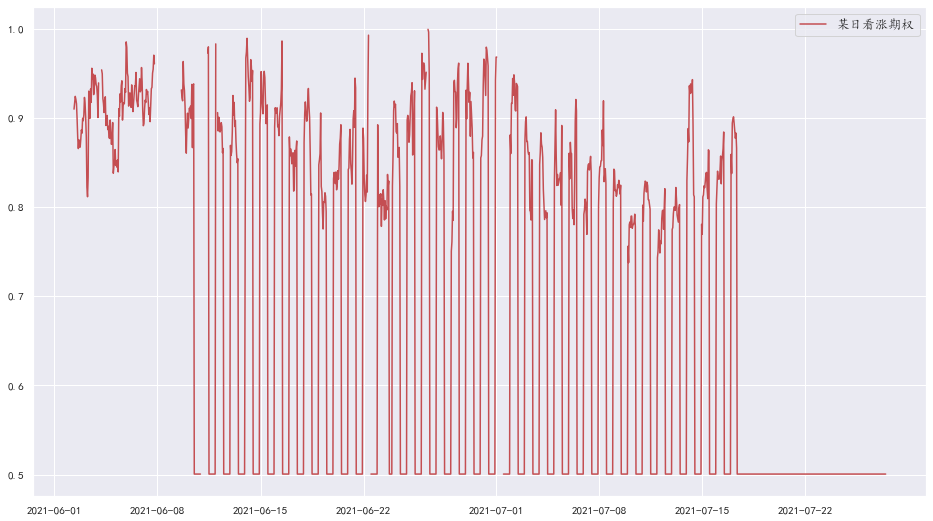

In [64]:
# 取某个到期日、某一天的看涨期权
df_option_smile_c = df[(df['T1'] == '2021-07-30') & (df['K'] == '40000') & (df['types'] == 'C')]
# df_option_smile_c
df_option_smile_c_final = pd.DataFrame()
# 原始数据开高收低单位为BTC，通过乘以BTC价格获得当时期权价格
df_option_smile_c[['open', 'high', 'low', 'close']] = df_option_smile_c.loc[:, ('open', 'high', 'low', 'close')].apply(lambda x: x * df_option_smile_c['btc_price'])
# 计算隐波
P_smile_c, S_smile_c, K_smile_c, T0_smile_c, T1_smile_c, types_smile_c = df_option_smile_c['close'].to_list(), df_option_smile_c['btc_price'].to_list(), df_option_smile_c['K'].to_list(), df_option_smile_c['candle_begin_time'].to_list(), df_option_smile_c['T1'].to_list(), df_option_smile_c['types'].to_list()  
impvol = []
for i in range(len(P_smile_c)):
    impvol.append(implied_volatility(P_smile_c[i], S_smile_c[i], K_smile_c[i], 0.04, T0_smile_c[i], T1_smile_c[i], types_smile_c[i]))
df_option_smile_c['impvol'] = impvol
df_option_smile_c_final = pd.concat([df_option_smile_c_final, df_option_smile_c], axis=0)
# df_option_smile_c_final['impvol'].fillna(method='ffill', inplace=True)

# 画图
plt.figure(figsize=(16,9))
plt.plot(df_option_smile_c_final['candle_begin_time'], df_option_smile_c_final['impvol'], label='某日看涨期权', color='r')
plt.legend(fontsize=13)
plt.show()

# 希腊值里的 Delta、Gamma、Vega、Theta、Rho

## Delta的引入

### Delta的数学概念

对于期权价格来说，标的物价格的变化和波动率是远远大于期权时间流逝的影响。这里有两个原因，第一个是因为标的物的价格变化是唯一可以直接改变期权内在价值的，内在价值的改变是直接影响到期权到期时候价格的变化。第二个原因是如果一旦波动率变大，本来较远的行权价的期权变得更有可能被变成实值期权，这样就会导致现在的期权价格变得更贵些。

期权的 Delta（$\Delta$）∶定义为期权价格变动与其标的资产价格变动的比率。它是描述期权价格与标的资产价格之间关系曲线的切线斜率。假定某看涨期权 delta 为 0.6，这意味着当股票价格变化一个很小的数量时，相应的期权价值变化大约等于股票价值变化的 60%。

![](options/1-3-delta.jpg)

当股票价格对应于点 A 时，期权价格对应于点 B，而 A 为图中所示直线的斜率。一般来讲，$\Delta= \partial c/\partial S$，其中 c 是看涨期权的价格，S 是股票的价格。

赫尔在《期权、期货及其它衍生品》中举例说，如果股票价格上涨 1 美元，期权价格将会上涨大约 0.6x1=0.6 美元；如果股票价格下跌 1 美元，期权价格将会下跌大约 0.6 美元。1 股股票本身的 delta 为 1.0。如果在 3天后的股票价格也许会升到 110 美元。那么，根据上图所示，股票价格上涨时会使 delta 变大，假设 delta 从0.6 增加到 0.65，如果仍要保持 delta 中性，投资者需要再买入 0.05×2000=100 股股票。当对冲头寸需要不断调整时，这种策略叫动态对冲（dynamical hedging）。

总体而言，Delta 是期权价值对于标的资产价格变化的敏感度。看涨期权 call 的 Delta 的理论值即为 N (d1)，其中：

$$
d_1 = \frac{\ln(\frac{S_0}K+(r+\sigma^2/2)T}{\sigma\sqrt T}
$$

看跌期权的 Delta 的理论值为 N (d1)-1，所以看跌期权的 Delta 是不大于 0 的负值。总体而言，看涨期权的 delta 值为 0 到 1，看跌期权的 delta 值为-1 到 0。

无股息股票期权上看涨期权的 delta，我们可以证明$\Delta$(看涨) = N d1 ，N（x）是标准正态分布的累积分布函数。无股息股票上看跌期权的 delta 为$\Delta$(看跌) = N(d1)-1。看涨期权合约的 Delta 和看跌期权合约的 Delta 的区别在于看跌期权多头的 Delta 值一般都是负值，这是因为股票价格的上升会导致看跌期权价格的下降。和看涨期权类似，平值看跌期权的 Delta 值一般为-0.5，实值看跌期权的 Delta 值一般在-1 至-0.5 之间;而虚值看跌期权的 Delta 值一般在-0.5 至 0 之间。

这里举一个例子，通常平值(at the money)看涨期权，即行权价格与现价相同的看涨期权 Delta 接近 0.5，虚值期权(out the money)行权价格高于现价的看涨期权的 Delta 小于 0.5，而实值期权(in the money)的 Delta 大于 0.5。看涨期权的实值程度越强，即标的资产现价高于行权价格越多，Delta 越接近于 1，反之 Delta 越接近 0。

Delta 值对于度量一个由标的资产与多种期权持仓所组成的投资组合的风险程度是非常有价值的。另外一个作用，就是作为在为持有资产做对冲时的对冲比例。另外一个相对被使用较少的现实意义，就是大致等于期权在到期时为实值期权(in the money)概率，但在真实的交易世界里，通常很少有交易员将 Delta 作为一个很值得信赖的概率。

麦克米伦在《麦克米伦谈期权》中描述了 delta 值与时间之间的关系。注意到，当标的从深度虚值(图示左侧)到深度实值(图示右侧)的变化过程中，剩余到期时间越长的期权，其 delta 值的变化幅度更为温和。反过来，短期期权的 delta 变化会越急剧。当短期认购期权为实值时(图示右侧，较高的曲线)，其 delta 值会向 1.00 快速靠拢；当短期认购期权为虚值时(图示左侧，较低的曲线)，delta 值会快速下跌至零。我们可以看到，在下图中，短期期权（例如三个月期）delta 线更陡峭，长期期权（例如一年期）delta 线更平缓。

![](options/1-4-delta.jpg)

奥姆斯特德在《期权入门与精通》中举了实际的例子，如果要计算看涨期权的 Delta，假设 XYZ 股票的价格为每股 30 美元，其对应的一份 3 月到期、执行价格为 30 美元的看涨期权合约(还有 3 个星期就到期)的价格为每股 2 美元。假设 XYZ 股票的价格上升 2 美元，达到每股 32 美元。通常这会导致此期权的价格也上升了 1 美元，达到每股 3 美元。

现在我们来计算这份 3 月到期、执行价格为 30 美元的看涨期权合约的 Delta 值。当股票价格上升 2 美元的时候，期权的价格也上升了 1 美元，因此，Delta 的计算过程就是 1/2=0.5，或者是 50%。也就是说，Delta值为 0.50 表示的是期权价格上升的幅度是股票价格的 50%。这个例子说明了期权合约的一个重要特征，即平值期权(执行价格和股票价格几乎相同的期权)的 Delta 值在通常情况下大概是 0.5。

另一个重要特征为，看涨期权里的实值期权（执行价格低于现在股票价格）的 Delta 值在通常情况下大于 0.5 且小于 1，深度实值期权的 Delta 值接近于 1。

第三个重要特征是，看涨期权里的虚值期权（执行价格高于现在股票价格）的 Delta 值在通常情况下小于0.5。执行价格越是高于股票价格，则对应的虚值期权的 delta 值也就越小。

我具体解释一下，即将要到期的实值期权的 Delta 值都接近 1.00，虚值期权的 Delta 值则接近 0。这里是因为实值期权接近到期日时，时间价值为 0，期权价值变化完全由内涵价值变化决定，此时 Delta 值为 1；虚值期权接近到期日时，内涵价值和时间价值都为 0，此时 Delta 值为 0。

美国股票市场由于机构投资者要保持 delta 中性，因此会出现股票价格上涨为保持 delta 中性继续购买股票；股票价格下跌为保持 delta 中性继续卖出股票，这种股票价格运动方向趋势性增强的现象，整体上美股呈现出越涨越涨，越跌越跌的趋势。因此美股的趋势性是比 A 股要更强的。

### 欧式期权的 Delta 值的表达式及 Python 实现

| 期权类型   | 方向 | Delta的表达式 |
|--------|----|-----------|
| 欧式看涨期权 | 多头 | Δ=N(d1)   |
|        | 空头 | Δ=-N(d1)  |
| 欧式看跌期权 | 多头 | Δ=N(d1)-1 |
|        | 空头 | Δ=1-N(d1) |

#### 定义欧式看涨、看跌期权Delta的计算函数

In [65]:
def delta_option(S, K, sigma, r, T, optype, positype):
    d1 = (np.log(S/K) + (r + pow(sigma, 2) / 2) * T) / (sigma * np.sqrt(T))
    if optype == 'C':
        if positype == 'long':
            delta = norm.cdf(d1)
        else:
            delta = -norm.cdf(d1)
    else:
        if positype == 'long':
            delta = norm.cdf(d1) - 1
        else: 
            delta = 1 - norm.cdf(d1)
    return delta

#### 基础资产价格与期权 Delta 的关系

此处使用作者之前用到的工商银行的数据进行模拟

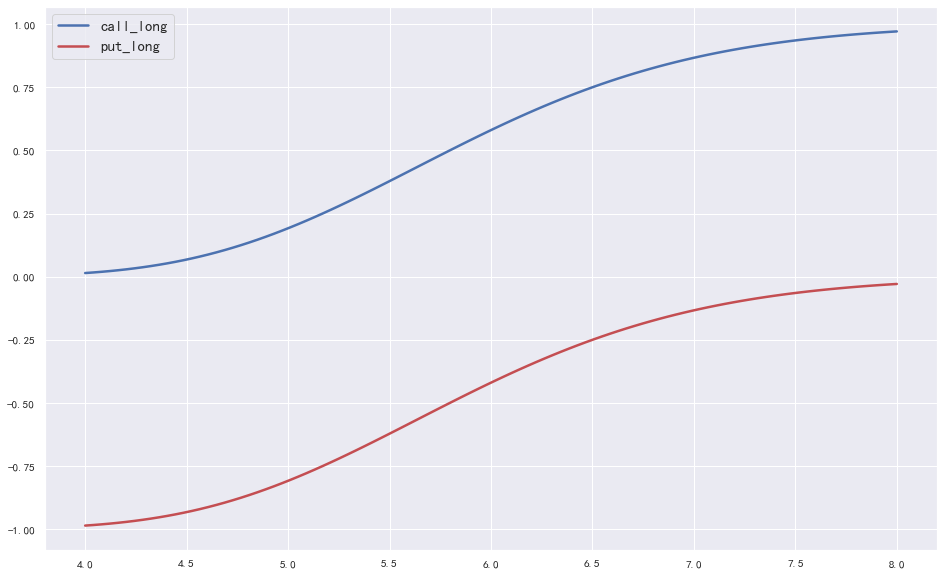

In [74]:
S_list = np.linspace(4.0, 8.0, 100)
delta_call = delta_option(S_list, 6, 0.24, 0.04, 0.5, 'C', 'long')
delta_put = delta_option(S_list, 6, 0.24, 0.04, 0.5, 'P', 'long')

plt.figure(figsize=(16, 10))
plt.plot(S_list, delta_call, 'b-', label=u'call_long', lw=2.5)
plt.plot(S_list, delta_put, 'r-', label=u'put_long', lw=2.5)
plt.legend(fontsize=15)
plt.show()

上图显示了看涨与看跌期权的 Delta 值与基础资产价格之间的变化关系。从图中可以梳理出 3 个特征：一是当基础资产价格增大的时候，期权的 Delta 值会增加；二是曲线的斜率始终是正的，用后面讨论的期权Gamma 值来描述就是期权的 Gamma 值始终为正；三是当基础资产价格小于期权执行价格（6 元／股）时，随着基础资产价格的增大，曲线的斜率递增；相反，当基础资产价格大于执行价格时，曲线的斜率递减。

#### 期权期限与期权 Delta 值的关系


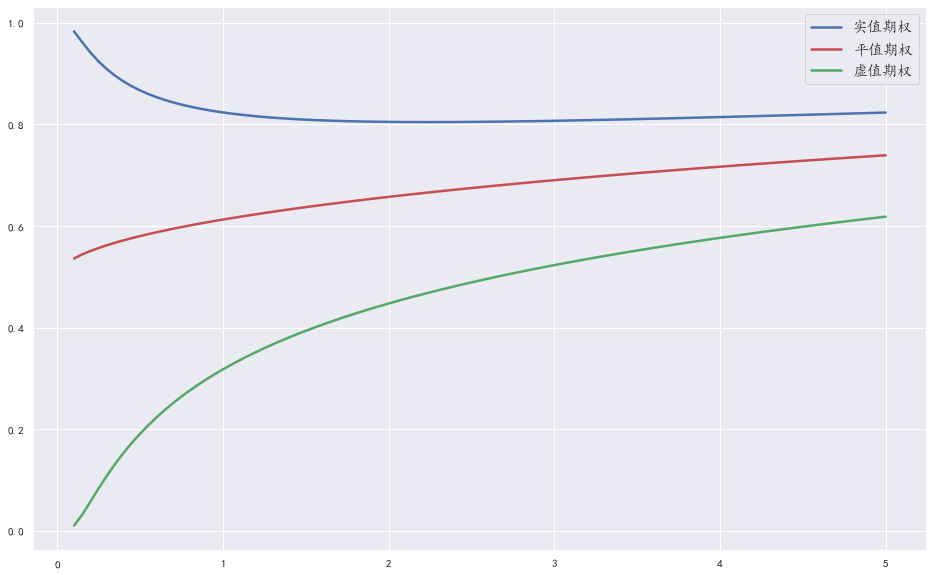

In [73]:
T_list = np.linspace(0.1, 5.0, 100)
delta_call_1 = delta_option(7, 6, 0.24, 0.04, T_list, 'C', 'long')
delta_call_2 = delta_option(6, 6, 0.24, 0.04, T_list, 'C', 'long')
delta_call_3 = delta_option(5, 6, 0.24, 0.04, T_list, 'C', 'long')

plt.figure(figsize=(16, 10))
plt.plot(T_list, delta_call_1, 'b-', label=u'实值期权', lw=2.5)
plt.plot(T_list, delta_call_2, 'r-', label=u'平值期权', lw=2.5)
plt.plot(T_list, delta_call_3, 'g-', label=u'虚值期权', lw=2.5)
plt.legend(fontsize=15)
plt.show()

上图中有 3 条曲线，由上往下的第 1 条曲线表示实值看涨期权多头的 Delta 值与期权期限之间的关系，这条曲线的特点是随着期权期限的增加，实值看涨期权的 Delta 值是先递减然后再缓慢递增；第 2 条曲线、第 3条曲线分别表示平价、虚值看涨期权多头的 Delta 值与期权期限之间的关系，显然平价、虚值期权的 Delta值均是期权期限的递增函数，但是虚值期权 Delta 值的边际增量则大于平价期权。

考虑到期权空头的希腊字母可以通过对期权多头的希腊字母取相反数直接得到，因此，限于篇幅，下面介绍的期权希腊字母将围绕着期权的多头展开讨论。

### Gamma 是 Delta 的变化量

王伟的《期权 36 课》里，对于希腊值有着非常深入的研究。Gamma 可以表示为 Delta 变化量与标的物价格变化量之比。如某一期权的 Delta 为 0.4，Gamma 值为 0.05，则表示期货价格上升 1 元，所引起 Delta 增加量为 0.05。Delta 将从 0.4 增加到 0.45。在其他 Greeks，变量不变的前提下，当股票价格发生微小变化时，期权 Delta 的变化值就是 Gamma。

因此，Gamma 值衡量的是标的价格每变化 1 点时，期权 delta 值的变化幅度。本质上说，它衡量了 delta 变化速度的快慢。

与 Delta 不同，无论看涨期权或是看跌期权的 Gamma 值均为正值。标的物价格上涨，看涨期权的 Delta 值由 0 向 1 移动，看跌期权的 Delta 值从-1 向 0 移动，即期权的 Delta 值从小到大移动，Gamma 值为正。股票价格下跌，看涨期权的 Delta 值由 1 向 0 移动，看跌期权的 Delta 值从 0 向-1 移动，即期权的 Delta 值从大到小移动，Gamma 值始终为正。

当平值期权的 Gamma 值最大时，深实值或深虚值期权的 Gamma 值则趋近于 0。随着时间临近到期日，平值期权的 Gamma 会升高，而虚值和实值期权的 Gamma 会降低，越临近到期，平值期权的 Gamma 越高。（当然这个结论其实在投资实践中并没有明显用处。）

接下来我们主要谈谈在中性策略下面一个比较成熟的策略 Gamma Scalping。这个策略的核心做法就是通过买入期权（做多 Gamma），然后来回赚标的物波动带来的价值。简单来说这个策略就是你付出一定的费用，去预测未来标的物会有大幅波动。如果在期权到期内波动不够大或者波动率朝着我们不利的方向，就会导致策略的亏损，也是所在的风险。所以这个策略一般喜欢在期权处于低波动率时使用。首先低波动率下，期权便宜，做多 Gamma 的成本相对就低一点，另外如果未来波动率会上升，我们做多 Vega 也同时可以赚到一些利润。低 IV 的状态下，Delta 和 Gamma 会更敏感一些，这样波动起来的时候，会给我们更多的利润。而高 IV 的状态下，Delta 和 Gamma 会显得不敏感，在同样的利润下，需要更大的波动才可以。总而言之，如果期权在短期内没有波动或者波动不足够大的话，整个策略是会有亏损的。

在数学上，一个期权交易组合的 gamma（Γ）是指交易组合 delta 的变化与标的资产价格变化的比率。这是交易组合关于标的资产价格的二阶导数.

当 gamma 很小时，delta 变化缓慢，这时为保证 delta 中性并不需要做太频繁的调整。但是 gamma 的值很大（正值或负值）时，della 对标的资产价格的变动就会很敏感，此时在一段时间内不对一个 delta 中性的投资组合做调整都将会是非常危险的。下图展示了这一点：当股票价格由 S 变成 S'时，delta 对冲时假设期权价格由 C 变成 C'，而事实上期权由 C 变成了 C’’。C'与 C’’的不同导致了对冲误差。这一误差的大小取决于期权价格与标的资产价格关系的凸性。gamma 值正是对这一凸性的度量。

![](options/1-5-gamma.jpg)

在布莱克斯科尔斯模型中，期权或组合值 X 只依赖于变量 s 与 t（因为$\sigma$与 r 都被假定为常数，而 t 对于期权的影响又要远小于股价 s），因此对于这个期权组合，它的泰勒展开式为：

$$
X(t+\Delta t, s+\Delta s)=X(t,s)+\frac{\partial X(t,s)}{\delta s}\Delta S+\frac{\partial X(t,s)}{\partial t}\Delta t+\frac12\frac{\partial^2X(t,s)}{\partial s^2}\Delta S^2+\frac12\frac{\partial^2X(t,s)}{\partial t^2}\Delta t^2+\frac{\partial^2X(t,s)}{\partial s\partial t}\Delta S\Delta t+\dots
$$

其中$\Delta S=S(t+\Delta t)-S(t)$

由于∆t的高阶项比较小，故我们可以将其忽略，得到近似表达式为：

$$
X(t+\Delta t, s+\Delta s)\approx X(t,s)+\Delta\times\Delta S+\Theta\Delta t+\frac12\Gamma\Delta S^2
$$

泰勒级数展开显示了在短时间内各个希腊值在交易组合价值变化中起的不同作用。如果标的资产的波动率为常数，作为标的资产价格 s 与时间 t 的函数，交易组合价值$\Pi$的泰勒展开式为

$$
\Delta\Pi=\frac{\partial\Pi}{\partial S}\Delta S+\frac{\partial\Gamma}{\partial t}\Delta t+\frac12\frac{\partial^2\Pi}{\partial S^2}\Delta S^2+\dots
$$

其中$\Delta\Pi$和$\Delta$S 分别对应于在短时间$\Delta$t 内$\Pi$与 S 的变化。由于 delta 中性时，delta 为 0。对于一个 deta 中性的交易组合，上式右端第一项为 0,因此$\Delta \Pi=\Theta\Delta t+\frac12\Gamma\Delta S^2$.在这里我们忽略阶数高于$\Delta$t 的项。

#### 期权的Gamma公式

期权的 Gamma（Γ）是指期权 Delta 值的变化与基础资产价格变化的比率。Gamma 是期权价值关于基础资产价格的二阶偏导数。

其中，Π依然表示期权的价值，S 依然表示期权基础资产价格。比如，期权 Gamma 等于 0.3，这就意味着当基础资产价格变化时，相应期权 Delta 值的变化约等于基础资产价格变化的 30％。根据布莱克斯科尔斯默顿模型，对于欧式看涨和欧式看跌期权的 Gamma 值的表达式均是：

$$
\begin{align}
&\Gamma=\frac{N'(d_1)}{S_0\sigma\sqrt T}\\
&其中，\\
&d_1=\frac{\ln(\frac{S_0}{K}+(r+\sigma^2/2)T}{\sigma\sqrt T}\\
& N'(x)=\frac1{\sqrt{2\pi}}e^{-x^2/2}\\
&为了便于建模，整理为：\\
&\Gamma=\frac{N'(d_1)}{S_0\sigma\sqrt T}=\frac1{S_0\sigma\sqrt{2\pi T}}e^{-d_1^2/2}\\
\end{align}
$$





In [4]:
def gamma_option(S, K, sigma, r, T):
    d1 = (np.log(S/K) + (r + pow(sigma, 2) / 2) * T) / (sigma * np.sqrt(T))
    return np.exp( -pow(d1, 2) / 2) / (S * sigma * np.sqrt(2 * np.pi * T))

#### 基础资产价格与期权Gamma的关系

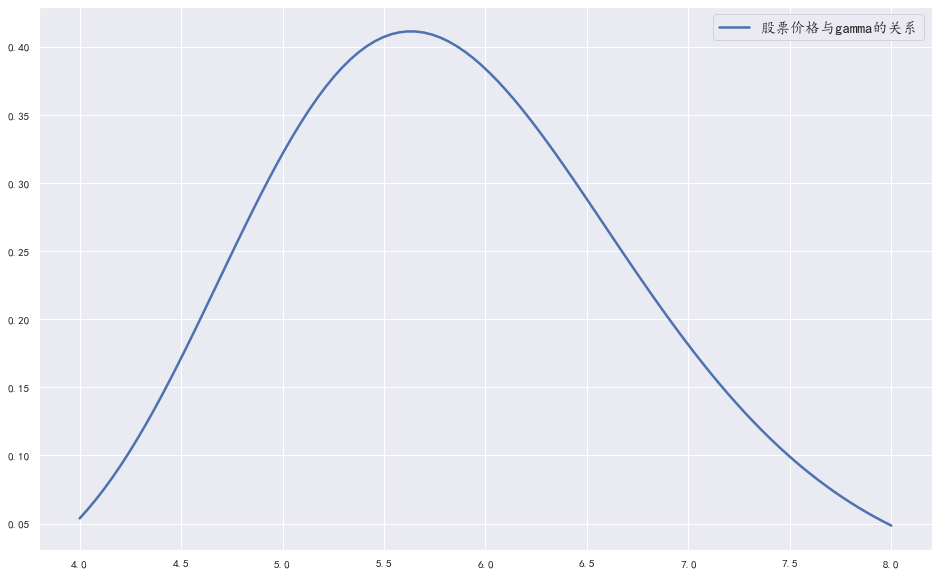

In [6]:
S_list = np.linspace(4.0, 8.0, 100)
gamma_list = gamma_option(S_list, 6, 0.24, 0.04, 0.5)
plt.figure(figsize=(16, 10))
plt.plot(S_list, gamma_list, 'b-', label=u'股票价格与gamma的关系', lw=2.5)
plt.legend(fontsize=15)
plt.show()

上图的曲线展示了期权的 Gamma 与基础资产价格之间的变化关系，这条曲线比较接近于正态分布曲线，并且该曲线可以分为两段，第 1 段是基础资产价格显著小于期权执行价格，也就是看涨期权是深度虚值、看跌期权是深度实值，期权 Gamma 是基础资产价格的递增函数；第 2 段是基础资产价格略小于和大于期权执行价格，期权 Gamma 是基础资产价格的递减函数。此外，当期权接近于平价期权时，也就是基础资产价格接近于期权执行价格时，期权 Gamma 值最大。

#### 期权期限与期权Gamma的关系

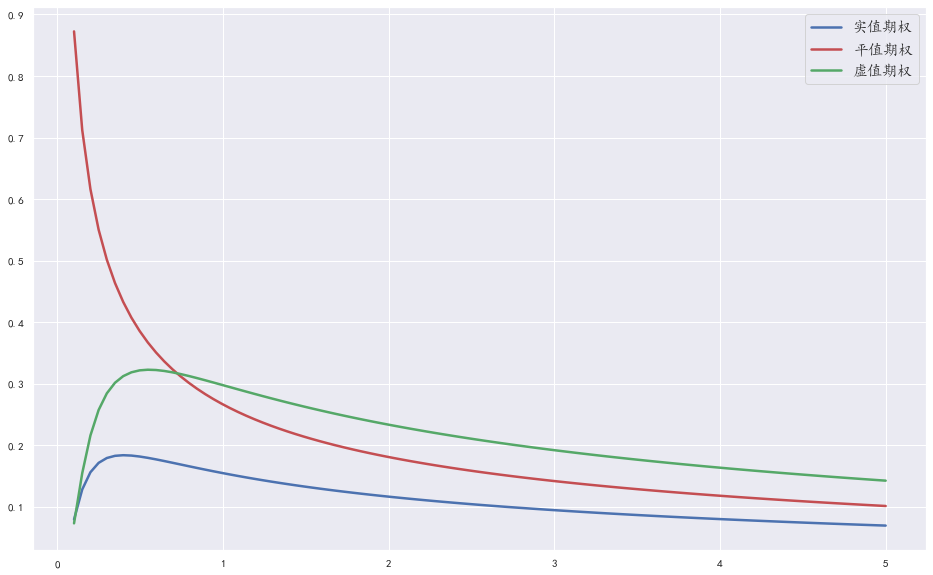

In [8]:
T_list = np.linspace(0.1, 5.0, 100)
gamma1 = gamma_option(7, 6, 0.24, 0.04, T_list)
gamma2 = gamma_option(6, 6, 0.24, 0.04, T_list)
gamma3 = gamma_option(5, 6, 0.24, 0.04, T_list)

plt.figure(figsize=(16, 10))
plt.plot(T_list, gamma1, 'b-', label=u'实值期权', lw=2.5)
plt.plot(T_list, gamma2, 'r-', label=u'平值期权', lw=2.5)
plt.plot(T_list, gamma3, 'g-', label=u'虚值期权', lw=2.5)
plt.legend(fontsize=15)
plt.show()

上图显示了平价期权、虚值期权和实值期权的 Gamma 与期权期限的关系。图中有 3 条曲线，从上往下的第1 条是平价期权，第 2 条是虚值期权，第 3 条是实值期权。对于平价期权而言，Gamma 是期权期限的递减函数；同时，期限短的平价期权 Gamma 很高，这意味着越接近合约到期日，平价期权的 Delta 值对于基础资产价格变动越敏感。此外，无论对于虚值期权还是实值期权，当期权期限比较短时，Gamma 是期限的递增函数；当期限拉长时 Gamma 则变成了期限的递减函数.

### Theta的引入

期权组合的 theta（$\Theta$）定义为在其他条件不变时，投资组合价值变化与时间变化的比率。Theta 就是度量期权价值随时间流失衰减的速率。一些投资者之前可能有疑问为什么做期权交易的时候明明选择的方向对了，最后却没有赚钱，问题往往就是出在 Theta 这里。

theta 有时称为组合的时间损耗（time decay）。对于一个无股息股票上的欧式看涨期权，计算 theta 的公式可以从布莱克斯科尔斯模型得出：

$$
\Theta=-\frac{S_0N'(d_1)\sigma}{2\sqrt T}-rKe^{-rT}N(d_2)\\
其中N'(x)=\frac1{\sqrt{2\pi}}e^{-x^2/2}为标准正态分布的密度函数。
$$

对于股票上的欧式看跌期权，计算 theta 的公式为：

$$
\Theta=-\frac{S_0N'(d_1)\sigma}{2\sqrt T}+rKe^{-rT}N(-d_2)\\
$$

因为N(−d2) = 1 − N(d2)，看跌期权的 theta 比相应看涨期权的 theta 高出$rKe^{−rT}$。

通常在计算 theta 时的时间是以天为单位，因此 theta 为在其他变量不变时，在一天过后交易组合价值的变化。为了计算每日历天的 t 上面计算 theta，公式必须除以 365。为了计算每个交易日的 theta，上面计算 theta的公式则除以 252。

期权的 theta 一般是负的，这是因为在其他条件不变的情况下，随着期限的减小，期权价值会降低。当股票价格很低时，theta 接近于零。对应于一个平值看涨期权，theta 很大而且是负值。当股票价格很高时，theta 接近于$rKe^{−rT}$。因此我们可以得到一个结论：当购买一个看涨期权时，不应购买平值期权，而应尽量购买虚值期权。

对于 Theta 通常的表示为时间过去一天期权所损失的价值，是假设在别的诸如波动率之类的市场条件都没有变化的情况下。比如，如果一个看涨期权的 Theta 为 0.2，假设今天这张看涨期权的价格为 5 美元，那么一天后它的价值应该为 4.8 美元，两天后为 4.6 美元。

因为 Theta 是度量期权价值衰减的指标，Gamma 里通常对 Theta 的表达都是一个负数， 在之前的例子里，所以就有一个具有-0.2Theta 的期权在别的市场条件保持不变时每天会流失 0.2 的价值。

平值期权随着时间临近到期，其 Theta 是在增加的。平值期权随单位时间衰减的价值是要大于实值和虚值期权的，并且衰减速度随着临近到期而递增。

在处于平值期权时，期权价值受到时间价值的变化较明显，这显然是因为，对于虚值期权，影响期权价值最大的是股票价格的变化，而不是时间变化。

#### Theta的数学公式

期权的 Theta（Θ）定义为在其他条件不变时，期权价值变化与时间变化的比率，即

$$
\Theta=\frac{\partial\Pi}{\partial T}\\
其中，\Gamma依然表示期权的价格，T 表示期权的期限。
$$

Theta 有时也被称为期权的时间损耗（time decay）。在其他条件不变的情况下，不论是看涨期权还是看跌期权，通常距离期权到期日越远，期权价值是越高的；距离期权到期日越近，期权价值则是越低的。所以在期权领域有这样一句话：“于期权的多头而言，时间流逝是敌人，对于期权的空头而言，时间流逝是密友。对于一个欧式看涨期权，计算 Theta 的公式可以通过布莱克斯科尔斯默顿模型得出，并且看涨期权与看跌期权是存在差异的，对于看涨期权的 Theta，计算公式如下：

$$
\begin{align}
&\Theta_{call}=-\frac{S_0N'(d_1)\sigma}{2\sqrt T}-rKe^{-rT}N(d_2)\\
&其中，\\
&d_1=\frac{\ln(\frac{S_0}{K}+(r+\sigma^2/2)T}{\sigma\sqrt T}\\
&d_2=\frac{\ln(\frac{S_0}{K}+(r-\sigma^2/2)T}{\sigma\sqrt T}=d_1-\sigma\sqrt T\\
&N'(x)=\frac1{\sqrt{2\pi}}e^{-x^2/2}\\
&因此，为了便于建模，上式经过整理可以得到\\
&\Theta_{call}=-\frac{S_0\sigma e^{-d_1^2/2}}{2\sqrt{2\pi T}}-rKe^{-rT}N(d_2)\\
&对于一个欧式股票看跌期权，Theta 的计算公式则是\\
&\Theta_{put}=-\frac{S_0\sigma e^{-d_1^2/2}}{2\sqrt{2\pi T}}+rKe^{-rT}N(d_2)=\Theta_{call}+rKe^{-rT}\\
\end{align}
$$

In [7]:
def theta_option(S, K, sigma, r, T, optype):
    d1 = (np.log(S/K) + (r + pow(sigma, 2) / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    theta_call = -(S * sigma * np.exp(-pow(d1, 2) / 2)) / (2 * np.sqrt(2 * np.pi * T)) - r * K * np.exp(-r * T) * norm.cdf(d2)
    if optype == 'C':
        theta = theta_call
    else:
        theta = theta_call + r * K * np.exp(-r * T)
    return theta

#### 基础资产价格与期权 Theta 的关系



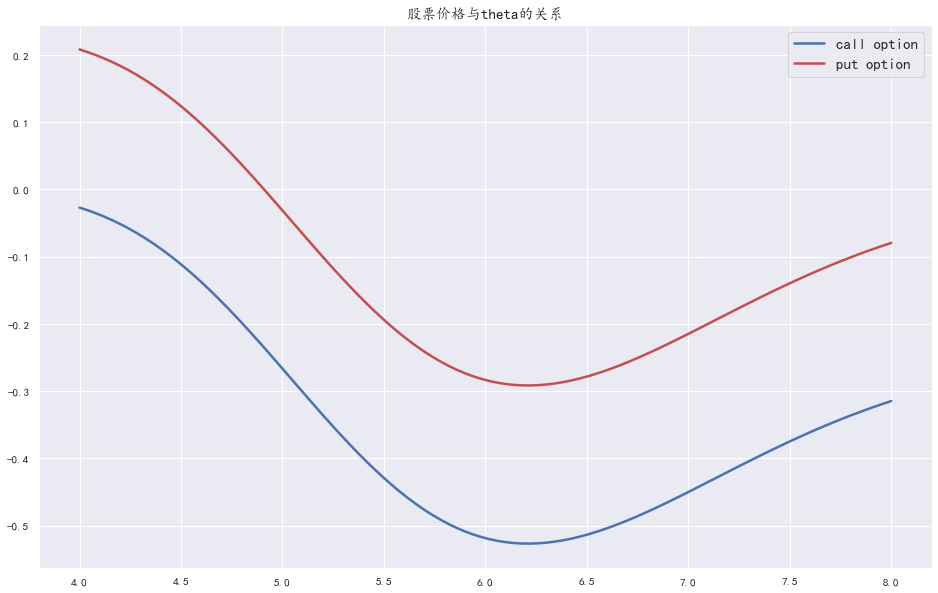

In [10]:
S_list = np.linspace(4.0, 8.0, 100)

theta_list1 = theta_option(S_list, 6, 0.24, 0.04, 0.5, 'C')
theta_list2 = theta_option(S_list, 6, 0.24, 0.04, 0.5, 'P')

plt.figure(figsize=(16, 10))
plt.plot(S_list, theta_list1, 'b-', label=u'call option', lw=2.5)
plt.plot(S_list, theta_list2, 'r-', label=u'put option', lw=2.5)
plt.title(u'股票价格与theta的关系', fontsize=15)
plt.legend(fontsize=15)
plt.show()

上图显示了看涨、看跌股票期权的 Theta 与基础资产价格之间关系的曲线。从图中可以得到如下 4 个结论：第一，无论是看涨期权还是看期权，Theta 与基础资产价格之间关系的曲线形状是很相似的；第二，在期权行权价格（6 元／股）附近，也就是接近于平价期权的时候，无论是看涨期权还是看跌期权，Theta 是负值并且绝对值很大，这就意味着期权的价值对时间的变化非常敏感；第三，当基础资产价格大于执行价格时，Theta 的绝对值处于下降阶段；第四，当基础资产价格小于执行价格时，对于看跌期权而言，随着基础资产价格不断减小，期权 Theta 将由负转正并趋近于某一正数，而看涨期权的 Theta 则趋近于零。

#### 期权期限与期权 Theta 的关系


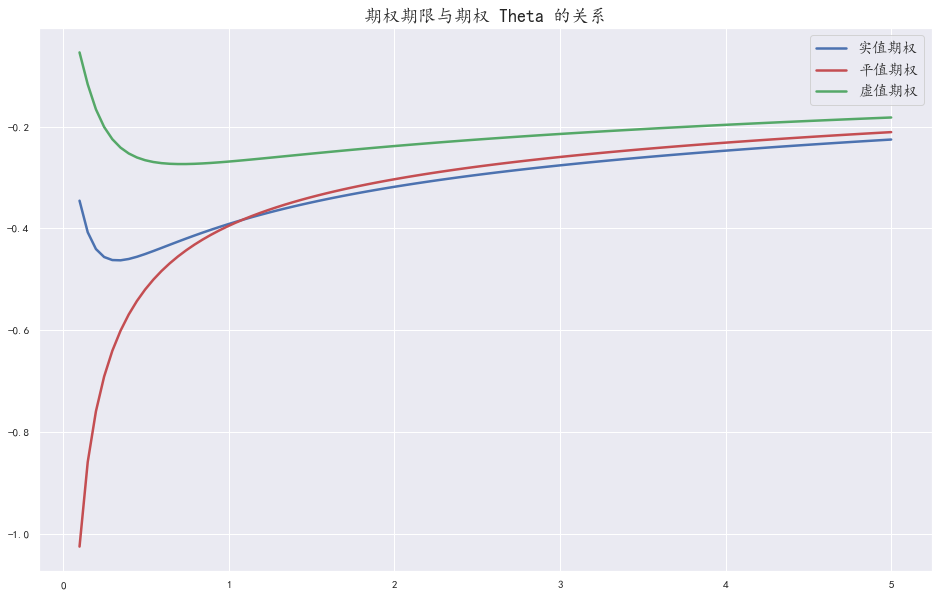

In [12]:
T_list = np.linspace(0.1, 5.0, 100)
theta1 = theta_option(7, 6, 0.24, 0.04, T_list, 'C')
theta2 = theta_option(6, 6, 0.24, 0.04, T_list, 'C')
theta3 = theta_option(5, 6, 0.24, 0.04, T_list, 'C')

plt.figure(figsize=(16, 10))
plt.plot(T_list, theta1, 'b-', label=u'实值期权', lw=2.5)
plt.plot(T_list, theta2, 'r-', label=u'平值期权', lw=2.5)
plt.plot(T_list, theta3, 'g-', label=u'虚值期权', lw=2.5)
plt.title(u'期权期限与期权 Theta 的关系', fontsize=18)
plt.legend(fontsize=15)
plt.show()

从图中可以得到以下 3 个结论：一是当期权期限越短（即越临近期到期日），平价期权的 Theta 绝对值越大，并且与实值期权、虚值期权在 Theta 上的差异也是最大的。对此，可以利用直觉来理解这一点，因为当期权是平价时，期权到期时行权的不确定性最大，所以平价期权的价值对时间的敏感性就很大；二是平价期权的 Theta 值是期权期限的递增函数，相反，虚值期权和实值期权的 Theta 值在期权期限较短时是期限的递减函数，在期限较长时则是期限的递增函数；三是当期权期限不断变长时，实值期权、平价期权、虚值期权的 Theta 将会趋近。

## 讨论 delta、theta 和 gamma 之间的关系

由股票价格服从对数正态分布的性质出发，我们可以得出 0 与 T 之间连续复利收益率的概率分布。将 0 与 T之间以连续复利的收益率记为 x，那么$S_T=S_0e^{xT}, x=\frac1T\ln\frac{S_T}{S_0}$.

无股息股票上单个衍生品的价格必须满足微分方程式$x=\frac1T\ln\frac{S_T}{S_0}$。 因此，由这些衍生产品所组成的资产组合π也一定满足布莱克斯科尔斯模型构成的微分方程。

$$
\begin{align}
&\frac{\partial\Pi}{\partial t}+rS\frac{\partial\Pi}{\partial S}+\frac12\sigma^2S^2\frac{\partial^2\Pi}{\partial S^2}=r\Pi\\
&\Theta+rS\Delta+\frac12\sigma^2S^2\Gamma=r\Pi\\
&如果投资组合是 Delta 中性的，则 Delta =0，可得\\
&\Theta+\frac12\sigma^2S^2\Gamma=r\Pi\\
&其中\Theta=\frac{\partial\pi}{\partial t},\Delta=\frac{\partial\pi}{\partial S},\Gamma=\frac{\partial^2\pi}{\partial S^2}\\
\end{align}
$$

这一公式说明当$\Theta$很大并且为正时，交易组合的 gamma 也很大，但为负，这一结论反过来也成立。这在理论上解释了对于 delta 中性的交易组合，我们可以将 theta 作为 gamma 的近似。
